# Data Anlysis

## Importing librairies

In [1]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

In [2]:
!pip install langdetect
!pip install names-dataset
!pip install bertopic
!pip install Wikidata
!pip install wordcloud
!pip install pyLDAvis
!pip install NRCLex
clear_output()

In [2]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

#Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

#Stats
import scipy.stats as stats

#LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

#WordCloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Topic visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#BERTopic
#from bertopic import BERTopic

#Targeted topics
from empath import Empath

#Sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [4]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()
clear_output()

In [5]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 \
[[3]](https://www.nltk.org/) NLKT documentation 

# Table of contents
### [1. Extracted Topics](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The topics](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Topics over time](#1.2)**

### [2. Targeted Topics ](#2)

&nbsp;&nbsp;&nbsp;**[2.1 The categories](#2.1)**


&nbsp;&nbsp;&nbsp;**[2.2 Categories over time](#2.2)**



### [3. Sentiments](#3)

&nbsp;&nbsp;&nbsp;**[3.1 The sentiments](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Plot sentiment analysis](#3.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Plot multi-sentiments](#3.1.2)

&nbsp;&nbsp;&nbsp;**[3.2 Sentiments over time](#3.2)**


### [4. Combined](#4)

&nbsp;&nbsp;&nbsp;**[4.1 Topics and sentiments](#4.1)**


&nbsp;&nbsp;&nbsp;**[4.2 Categories and sentiments](#4.2)**



## Context

All the preprocessing and data preparation have been done in `blabla.ipynb`. In this notebook, we will focus on the analysis of the information we obtained.

In [6]:
#Loadinf our complete dataset
movies = pd.read_pickle('data/movies_aug_bert+SA.pkl')

In [7]:
multi_sentiments=['fear','anger','trust','surprise','sadness','disgust','joy','anticipation']
for key in multi_sentiments:
    movies['multi_{}'.format(key)]=movies.multi_scores.apply(lambda score_dict: score_dict['{}'.format(key)] if '{}'.format(key) in score_dict else 0)

In [8]:
movies.head()

WikiMovieID FreeMovieID                      Title ReleaseDate     Revenue  \
0       975900   /m/03vyhn             Ghosts of Mars  2001-08-24  14010832.0   
1      9363483  /m/0285_cd           White Of The Eye        1987         NaN   
2       261236   /m/01mrr1          A Woman in Flames        1983         NaN   
3     18998739  /m/04jcqvw  The Sorcerer's Apprentice        2002         NaN   
4      6631279   /m/0gffwj                Little city  1997-04-04         NaN   

   Runtime           Languages                   Countries  \
0     98.0  [English Language]  [United States of America]   
1    110.0  [English Language]            [United Kingdom]   
2    106.0   [German Language]                   [Germany]   
3     86.0  [English Language]              [South Africa]   
4     93.0  [English Language]  [United States of America]   

                                              Genres  \
0  [Thriller, Science Fiction, Horror, Adventure,...   
1  [Thriller, Erotic thriller, Psychological thri...   
2                                            [Drama]   
3    [Family Film, Fantasy, Adventure, World cinema]   
4  [Romantic comedy, Ensemble Film, Comedy-drama,...   

                                                Plot  ... compound_score  \
0  Set in the second half of the 22nd century, th...  ...        -0.9913   
1  A series of murders of rich young women throug...  ...        -0.9983   
2  Eva, an upper class housewife, becomes frustra...  ...         0.9604   
3  Every hundred years, the evil Morgana  returns...  ...        -0.8885   
4  Adam, a San Francisco-based artist who works a...  ...        -0.7097   

                                        multi_scores multi_fear multi_anger  \
0  {'fear': 0.16296296296296298, 'anger': 0.13333...   0.162963    0.133333   
1  {'fear': 0.1751412429378531, 'anger': 0.135593...   0.175141    0.135593   
2  {'fear': 0.0673076923076923, 'anger': 0.105769...   0.067308    0.105769   
3  {'fear': 0.08163265306122448, 'anger': 0.12244...   0.081633    0.122449   
4  {'fear': 0.07317073170731707, 'anger': 0.04878...   0.073171    0.048780   

  multi_trust multi_surprise multi_sadness multi_disgust multi_joy  \
0    0.111111       0.029630      0.088889      0.081481  0.029630   
1    0.073446       0.028249      0.107345      0.050847  0.033898   
2    0.125000       0.067308      0.038462      0.067308  0.134615   
3    0.061224       0.081633      0.081633      0.081633  0.040816   
4    0.146341       0.073171      0.073171      0.073171  0.121951   

   multi_anticipation  
0            0.051852  
1            0.045198  
2            0.105769  
3            0.122449  
4            0.073171  

[5 rows x 49 columns]

# 1. Extracted Topics <a id='1'></a>

## 1.1 The topics <a id='1.1'></a>

Idea for visualization:  
-Topic: Bubble with topics and words inside (see Green Peace)  
-Evolution over time: heatpmap(Green Peace)  
-Projection plot of topic (Green Peace)  


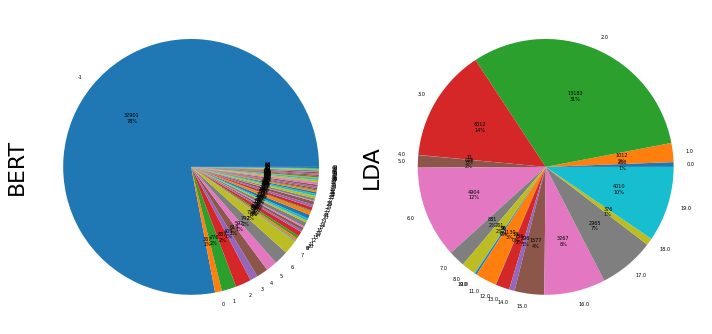

In [9]:
def label_function(val):
    return f'{val / 100 * len(movies):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
movies.groupby('BERT').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax1)
movies.groupby('Topic').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax2)
ax1.set_ylabel('BERT', size=22)
ax2.set_ylabel('LDA', size=22)
plt.tight_layout()
plt.show()

In [ ]:
#Creation of the data for flourish plot
topic_words_dict = pd.read_pickle('data/words_per_topic.pkl')

topic_words = pd.DataFrame()
rep = movies.groupby(['BERT']).size()

for word in topic_words_dict:
    for nb in range(0,10):
        new_row = {'Words':topic_words_dict[word][nb][0], 'Word_score':topic_words_dict[word][nb][1], 'Topic':word, 'Topic_rep':rep[word]}
        topic_words = topic_words.append(new_row, ignore_index=True)

In [8]:
topic_words["Combined_rep"]=topic_words["Word_score"]*topic_words["Topic_rep"]
topic_words

Words  Word_score  Topic  Topic_rep  Combined_rep
0       father    0.011736      0        367      4.307105
1       police    0.010656      0        367      3.910847
2       family    0.009785      0        367      3.591162
3         raja    0.009695      0        367      3.558182
4        comes    0.008873      0        367      3.256487
..         ...         ...    ...        ...           ...
195      three    0.011765     19        207      2.435330
196   strasser    0.010974     19        207      2.271644
197  professor    0.009296     19        207      1.924313
198     cerina    0.009104     19        207      1.884510
199     stooge    0.008583     19        207      1.776654

[200 rows x 5 columns]

### 1.1.1 With LDA <a id='1.1.1'></a>

### @.1.1 Data preparation <a id='3.1.1'></a>

#### Prepare bi-grams and tri-grams

In [ ]:
tokens = plot_summaries['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [ ]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

### @.1.2 Implementation <a id='3.1.2'></a>

In [ ]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

### @.1.3 Model evaluation <a id='3.1.3'></a>

(by checking how many topics a word exists in)

In [ ]:
topics_ = dict()
for i,topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    topics_[i]=topic

In [ ]:
"""
Counts for each word the number of topics that include it
"""
def count_words(topics_):
    counts = dict()
    for i in topics_:
        for word in topics_[i]:
            if word[0] in counts:
                counts[word[0]]+=1
            else:
                counts[word[0]]=1
    return counts

def takeSecond(elem):
    return elem[1]

In [ ]:
counts = count_words(topics_)
repeated_words = [(k,v) for k,v in counts.items() if v>=4]
repeated_words.sort(reverse=True, key = takeSecond)
repeated_words

### @.1.4 Resulting topics <a id='3.1.4'></a>

In [ ]:
for i in topics_:
    message = "Topic {} : ".format(i) 
    words = str([k for (k,v) in topics_[i]])
    print(message+words)
    print()

### EY.1.5 Topic Visualizations <a id='3.1.5'></a>

Unfortunately, since the plot is interactive when we push the notebook to github it disappears. Hopefully, by milestone 3 we can find a way to host it in a github page. In the meantime, you can find a [screenshot](https://github.com/epfl-ada/ada-2022-project-adaccord/blob/main/topic_visualiation.png) of it in our root repository.

In [ ]:
%matplotlib inline
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### 3.1.6 Assigning topics to movies <a id='3.1.6'></a>

In [ ]:
def most_probable_topic(possible_topics):
    possible_topics.sort(reverse=True, key = takeSecond)
    return possible_topics[0][0]

In [ ]:
chosen_topics = list()
for plot in tqdm(corpus):
    possible_topics = lda_model[plot]
    chosen_topic = most_probable_topic(possible_topics)
    chosen_topics.append(chosen_topic)

chosen_topics = np.array(chosen_topics)

In [ ]:
topics_df = pd.DataFrame(chosen_topics, columns = ["Topic"]) #Rename this to Topic_LDA

topics_df["Index"] = topics_df.index

display(topics_df.head())

In [ ]:
plot_summaries["Index"] = plot_summaries.index

plot_summaries = plot_summaries.merge(topics_df, left_on="Index", right_on="Index").drop(columns=["Index"])

In [ ]:
plot_summaries[["WikiMovieID", "Plot", "Topic"]].head() # Can merge again with movies 

### 1.1.2 With BERT <a id='1.1.2'></a>

[BERTopic](https://maartengr.github.io/BERTopic/index.html) is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. We will use this model to extract once more topics for each movie plots. The reason we repeat this process twice is so we can compare the results between them and by doing so verify them. In the end we will hopefully find a way to merge our results into a more concrete topic prediction.

Labels for the top 10 most common topics.

In [7]:
#bert_topics = model.generate_topic_labels()

bert_topics = pd.read_pickle('predictions/bert_topics.pkl')
bert_topics = pd.DataFrame(bert_topics, columns = ["Bert_Topic"])
bert_topics.head(10)

Bert_Topic
0        -1_film_father_life
1     0_father_police_family
2  1_police_murder_detective
3           2_town_men_horse
4     3_mother_father_family
5       4_earth_planet_space
6      5_ship_island_captain
7         6_wong_kong_master
8        7_tokyo_conan_japan
9       8_tells_home_husband

Visualization of the data set with the BERT topics.

## 1.2 Topics over time<a id='1.2'></a>

In [69]:
movies["year"] = pd.to_datetime(movies.ReleaseDate, errors="coerce").dt.year
movies["five_year_period"] = movies.year//5*5

# A lot of the ReleaseDate are not filled in the initial dataset which leads to NaT (and eventually NaN) values when converting to datetime
movies_with_year = movies[~movies.year.isna()]
print("We could extract the year of the release date for {:.2f}% of the movies".format(len(movies_with_year)/len(movies)*100))

We could extract the year of the release date for 93.80% of the movies


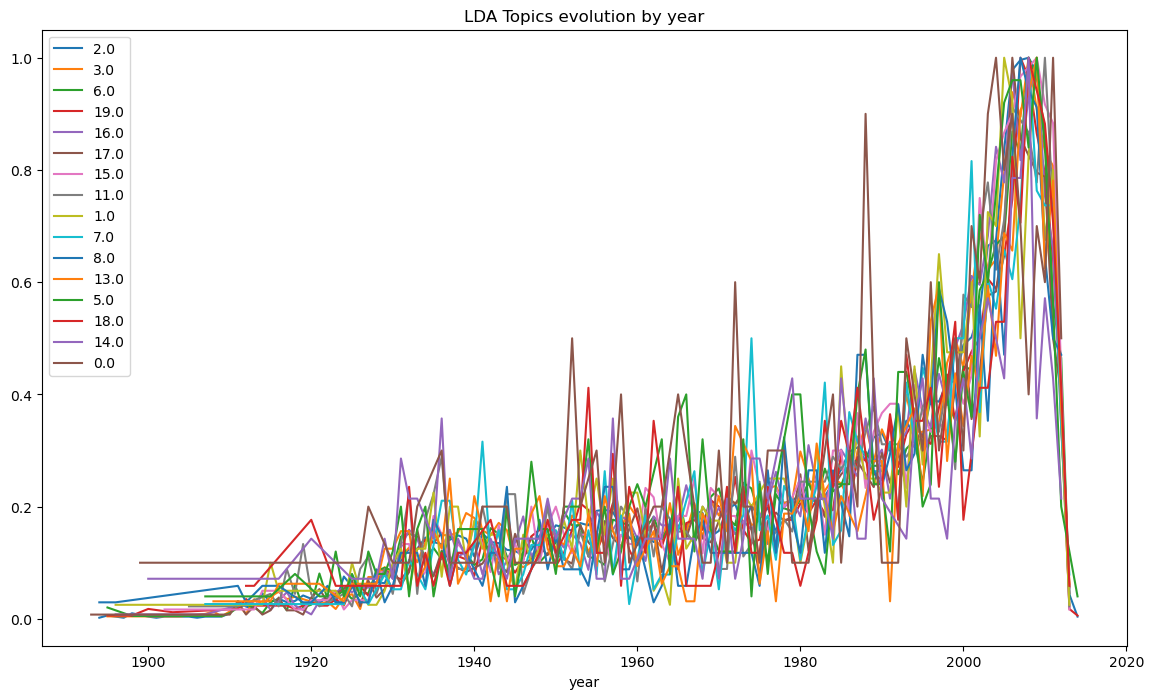

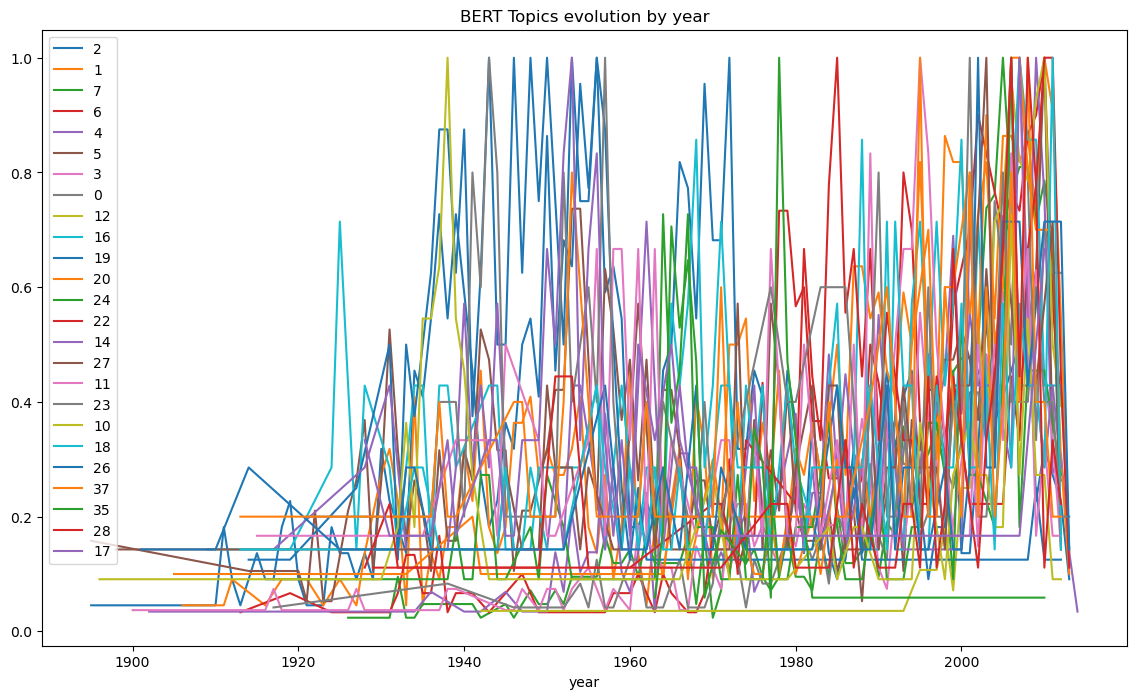

In [9]:
# Unique LDA topics with at least 100 movies assigned
topics_LDA = movies["Topic"].value_counts(dropna=True) 
topics_LDA = topics_LDA[topics_LDA>100].index.tolist()

fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["year"]).size()
    temp = temp/temp.max()   #should we divide by the movies_with_year.groupby(["year"]).size() ???
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by year")
fig = plt.legend()
fig = plt.show()

# Unique BERT topics with at least 100 movies assigned
topics_BERT = movies["BERT"].value_counts(dropna=False) 
topics_BERT = topics_BERT[topics_BERT>100].index.tolist()
## -1 goes to unclassfied movies
topics_BERT.remove(-1)

fig = plt.figure(figsize=(14,8))
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["year"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by year")
fig = plt.legend()
fig = plt.show()

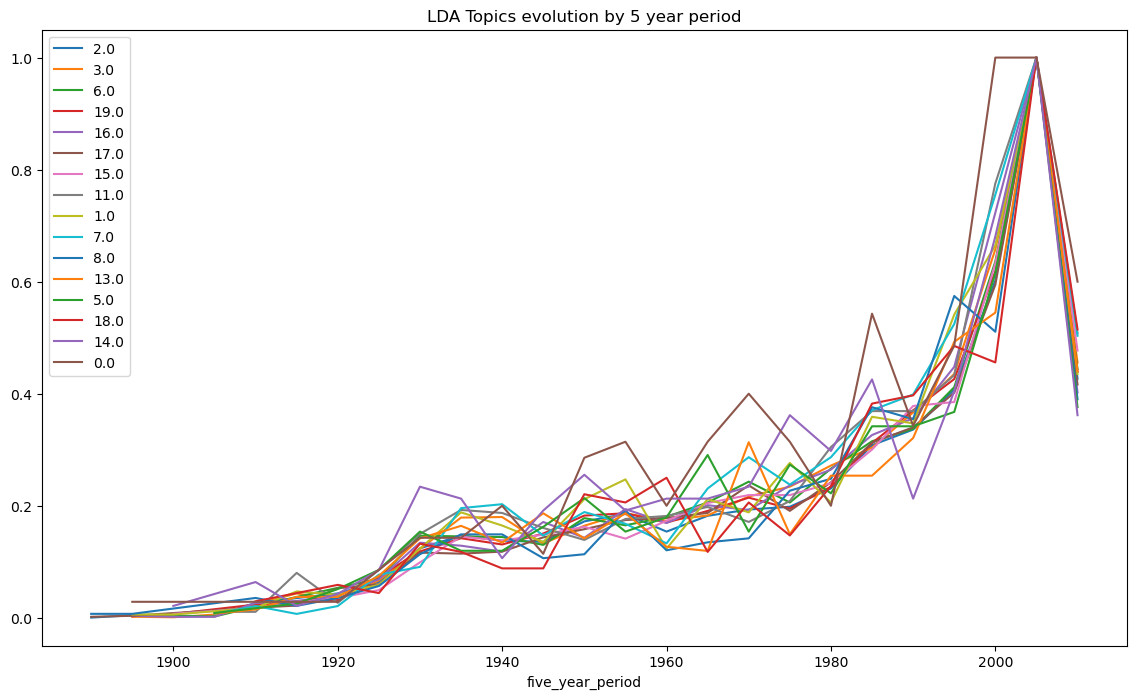

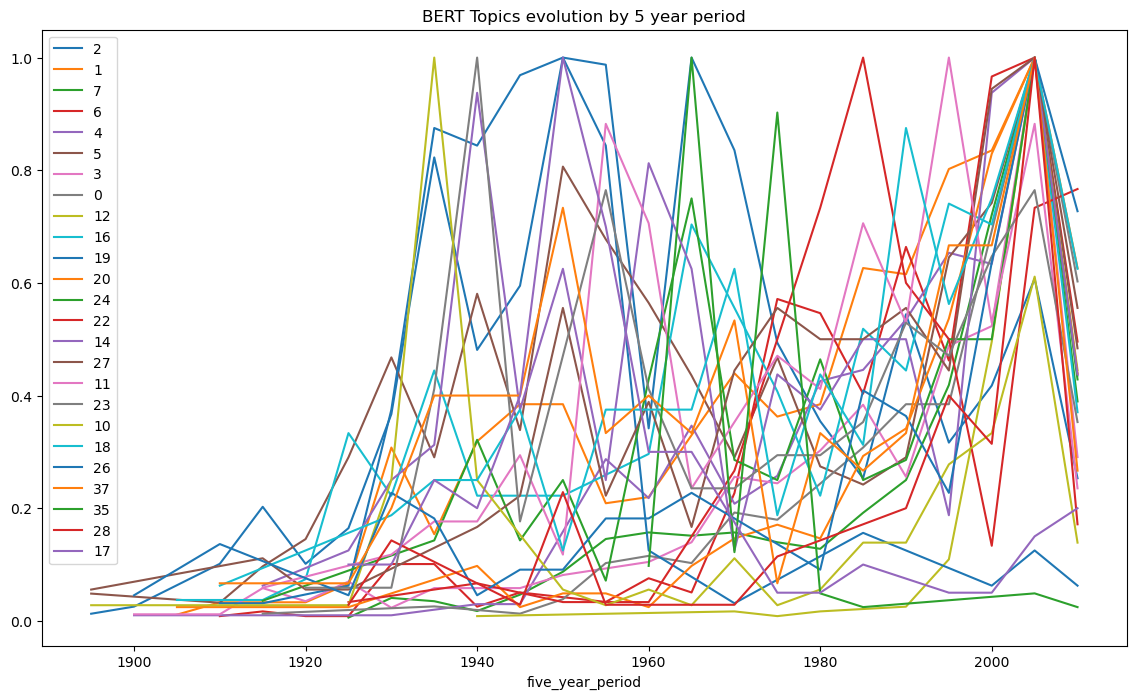

In [13]:
fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

fig = plt.figure(figsize=(14,8)) 
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

Last graph actually could be useful to draw some results. Now it doesn't show (so i'll have to make it show somehow) but if you plot just 1 topic (instead of all of them) you can see that for a few topics there was an interest eirther for a few decades and then it died out or the other way around. Depending on which topics these are (still a number i have to get real tags/names) it could be interesting. 

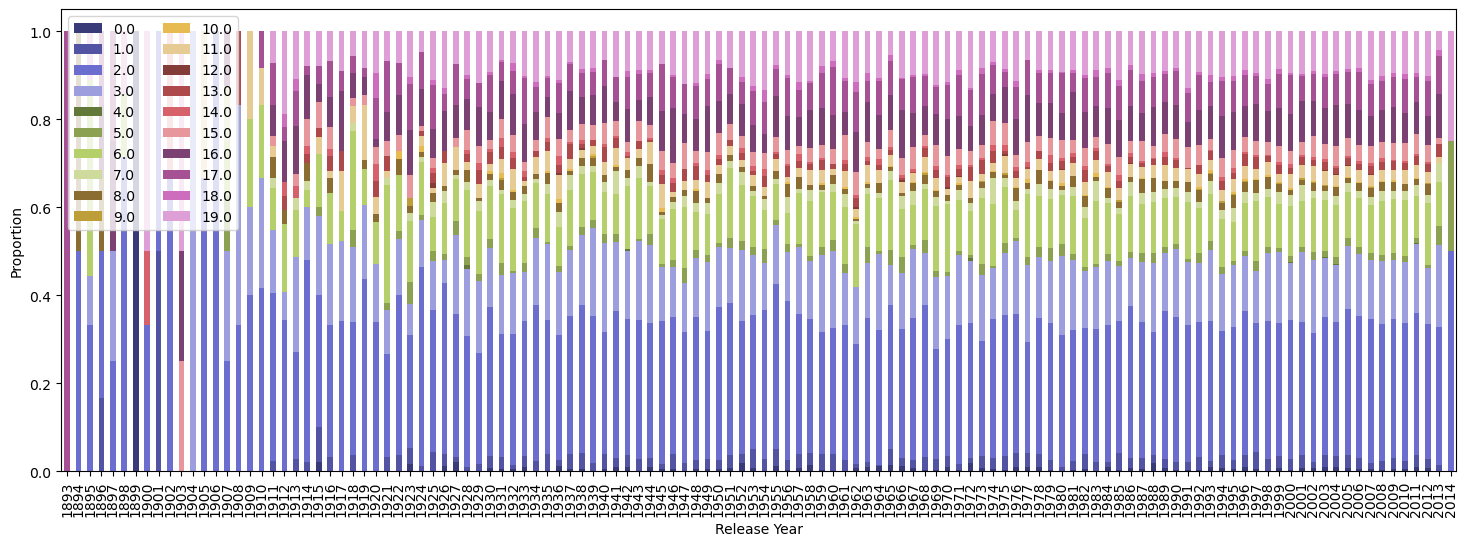

In [14]:
#Evolution over year LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["year"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

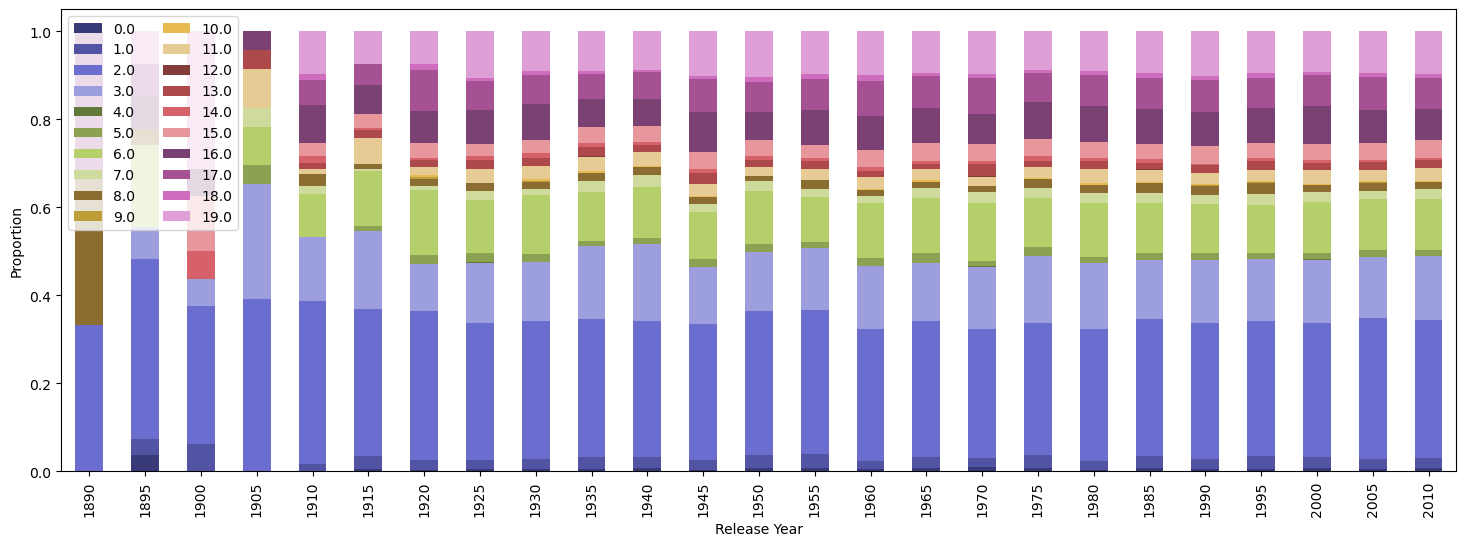

In [15]:
#Evolution over 5years LDA topics
cross_tab_prop = pd.crosstab(index=movies_with_year["five_year_period"].astype(int),
                             columns=movies_with_year["Topic"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab20b', 
                    figsize=(18, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

In [16]:
bert_topics.iloc[1].values

array(['0_father_police_family'], dtype=object)

In [17]:
BERT_movies_with_year = movies_with_year[movies_with_year['BERT'].isin(topics_BERT)]
#Adding the names of the BERT topics into the data Frame (should we do it earlier)?
BERT_movies_with_year['BERT_names']=bert_topics.iloc[BERT_movies_with_year['BERT'].astype(int)+1].values
BERT_movies_with_year.head() #there is a warning but it does what I want (:

/var/folders/k_/c3cbvfzs61374h16mfb1dxb00000gn/T/ipykernel_13656/4111283085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BERT_movies_with_year['BERT_names']=bert_topics.iloc[BERT_movies_with_year['BERT'].astype(int)+1].values


WikiMovieID FreeMovieID                                          Title  \
0        975900   /m/03vyhn                                 Ghosts of Mars   
10     21926710  /m/05p45cv                                  White on Rice   
21     25960460  /m/0b6kc_5                                 Daddy and Them   
36     16686643  /m/03ymtlq  One Small Step: The Story of the Space Chimps   
40     25413122  /m/04j1nd9                        Drums in the Deep South   

   ReleaseDate     Revenue  Runtime           Languages  \
0   2001-08-24  14010832.0     98.0  [English Language]   
10        2009         NaN     82.0                  []   
21        2001         NaN    101.0  [English Language]   
36        1995         NaN     60.0                  []   
40        1951         NaN     87.0  [English Language]   

                                  Countries  \
0                [United States of America]   
10               [United States of America]   
21  [United States of America, Netherlands]   
36               [United States of America]   
40               [United States of America]   

                                               Genres  \
0   [Thriller, Science Fiction, Horror, Adventure,...   
10     [Romantic comedy, Romance Film, Comedy, Indie]   
21                             [Black comedy, Comedy]   
36                                      [Documentary]   
40              [Action/Adventure, Western, War film]   

                                                 Plot  ... multi_anger  \
0   Set in the second half of the 22nd century, th...  ...    0.133333   
10  Jimmy ([[Hiroshi Watanabe  loves dinosaurs and...  ...    0.038462   
21  Ruby and Claude Montgomery are a very insecure...  ...    0.150000   
36  Told through archival photos and footage, spac...  ...    0.031250   
40  Best friends Clay Clayburn and Will Denning gr...  ...    0.086957   

   multi_trust multi_surprise multi_sadness multi_disgust multi_joy  \
0     0.111111       0.029630      0.088889      0.081481  0.029630   
10    0.153846       0.038462      0.076923      0.076923  0.076923   
21    0.050000       0.050000      0.200000      0.100000  0.050000   
36    0.187500       0.031250      0.031250      0.000000  0.125000   
40    0.130435       0.017391      0.043478      0.017391  0.069565   

   multi_anticipation    year five_year_period              BERT_names  
0            0.051852  2001.0           2000.0    4_earth_planet_space  
10           0.076923  2009.0           2005.0     7_tokyo_conan_japan  
21           0.050000  2001.0           2000.0  3_mother_father_family  
36           0.187500  1995.0           1995.0    4_earth_planet_space  
40           0.130435  1951.0           1950.0        2_town_men_horse  

[5 rows x 52 columns]

In [18]:
colors=[[0.22352941, 0.23137255, 0.4745098,  1.        ],
        [0.32156863, 0.32941176, 0.63921569, 1.        ],
        [0.61176471, 0.61960784, 0.87058824, 1.        ],
        [0.38823529, 0.4745098,  0.22352941, 1.        ],
        [0.54901961, 0.63529412, 0.32156863, 1.        ],
        [0.80784314, 0.85882353, 0.61176471, 1.        ],
        [0.54901961, 0.42745098, 0.19215686, 1.        ],
        [0.74117647, 0.61960784, 0.22352941, 1.        ],
        [0.90588235, 0.79607843, 0.58039216, 1.        ],
        [0.51764706, 0.23529412, 0.22352941, 1.        ],
        [0.67843137, 0.28627451, 0.29019608, 1.        ],
        [0.90588235, 0.58823529, 0.61176471, 1.        ],
        [0.48235294, 0.25490196, 0.45098039, 1.        ],
        [0.64705882, 0.31764706, 0.58039216, 1.        ],
        [0.19215686, 0.50980392, 0.74117647, 1.        ],
        [0.41960784, 0.68235294, 0.83921569, 1.        ],
        [0.90196078, 0.33333333, 0.05098039, 1.        ],
        [0.99215686, 0.55294118, 0.23529412, 1.        ],
        [0.19215686, 0.63921569, 0.32941176, 1.        ],
        [0.45490196, 0.76862745, 0.4627451 , 1.        ],
        [0.45882353, 0.41960784, 0.69411765, 1.        ],
        [0.61960784, 0.60392157, 0.78431373, 1.        ],
        [0.38823529, 0.38823529, 0.38823529, 1.        ],
        [0.58823529, 0.58823529, 0.58823529, 1.        ]]
import matplotlib.colors as mcolors
colors_tab20b =  plt.cm.get_cmap('tab20b')
#print(colors_tab20b([0,1,3,4,5,7,8,9,11,12,13,15,16,17]))
colors_tab20c =  plt.cm.get_cmap('tab20c')
#print(colors_tab20c([0,1,4,5,8,9,12,13,16,17]))
#colors = np.vstack((colors_tab20b,colors_tab20c))
#print(colors)
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

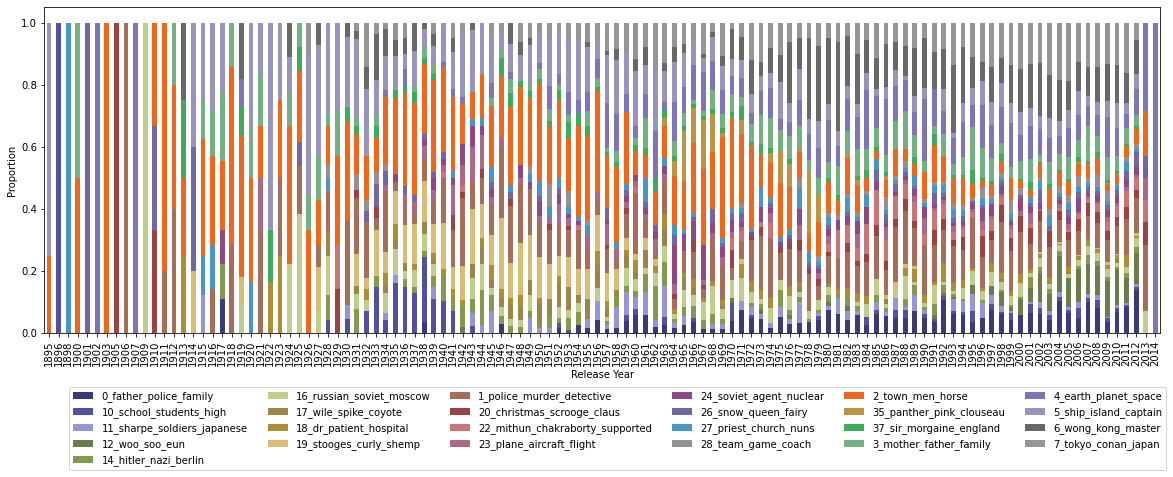

In [19]:
#Evolution over year BERT topics

cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["year"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(20, 6))

plt.legend(ncol=6,bbox_to_anchor=(1.01, -0.15))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

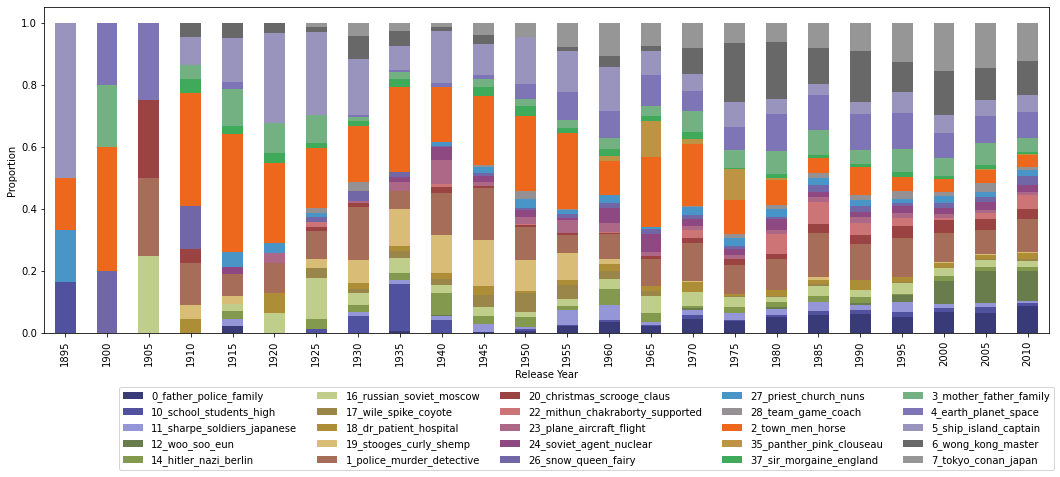

In [20]:
#evolution over 5yers BERT topics
cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["five_year_period"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=mymap, 
                    figsize=(18, 6))

plt.legend(ncol=5,bbox_to_anchor=(1.01, -0.15)) #ncol=1,bbox_to_anchor=(1.01, 1.0))
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()

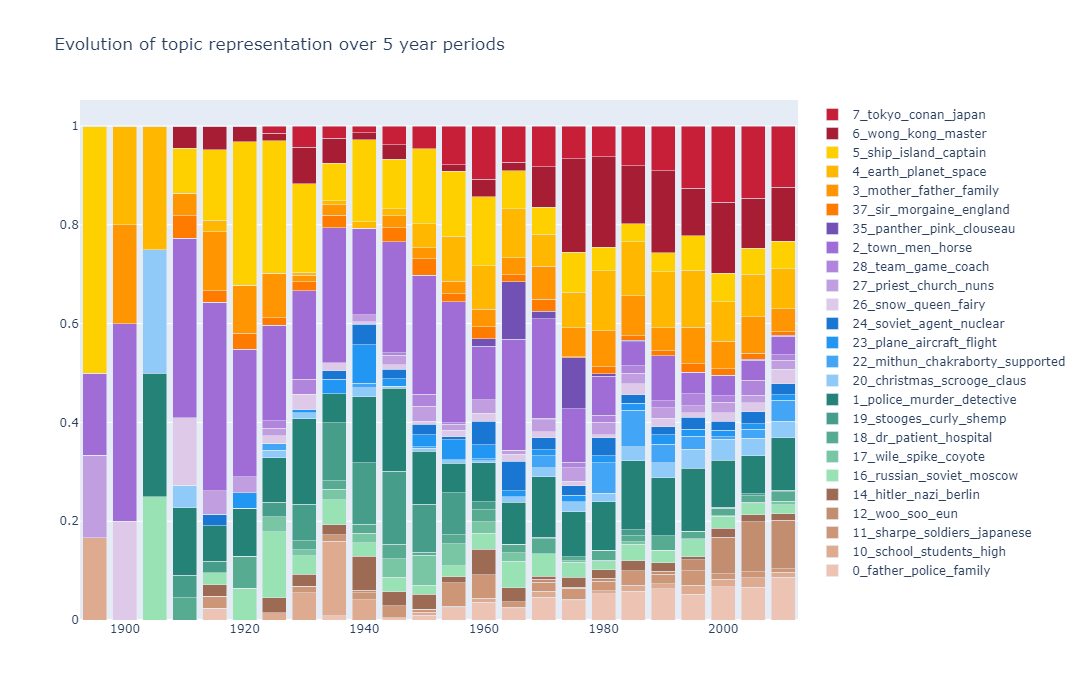

In [22]:
import plotly.graph_objects as go

# Original colour palette leaving it here just in case it's needed elsewhere
# Shades of 
colours = ["DEC9E9", "C19EE0", "B185DB", "A06CD5", "7251B5", "6247AA",   #violet
           "99E2B4", "78C6A3", "56AB91", "469D89", "248277", "036666",   #green
           "FF7B00", "FF9500", "FFAA00", "FFB700", "FFD000", "FFEA00",   #yellow
           "641220", "85182A", "A71E34", "B21E35", "C71F37", "E01E37",   #red
           "E3F2FD", "90CAF9", "42A5F5", "2196F3", "1976D2", "0D47A1",   #blue
           "FF0A54", "FF5C8A", "FF85A1", "FF99AC", "F9BEC7", "FAE0E4",   #pink
           "EDC4B3", "DEAB90", "CD9777", "C38E70", "9D6B53", "774936"]   #brown

colours = ["EDC4B3", "DEAB90", "CD9777", "C38E70", "9D6B53", 
           "99E2B4", "78C6A3", "56AB91", "469D89", "248277", 
           "90CAF9", "42A5F5", "2196F3", "1976D2", 
           "DEC9E9", "C19EE0", "B185DB", "A06CD5", "7251B5", 
           "FF7B00", "FF9500", "FFB700", "FFD000",  
           "A71E34",  "C71F37", ]


colours = ["#"+colour for colour in colours]

# Same as before - Can be deleted if we keep all graphs 
cross_tab_prop = pd.crosstab(index=BERT_movies_with_year["five_year_period"].astype(int),
                             columns=BERT_movies_with_year["BERT_names"],
                             normalize="index")

plot_data = []
for i, x in enumerate(cross_tab_prop.columns):
    plot_data.append(go.Bar(name=str(x), x=cross_tab_prop.index, y=cross_tab_prop[x], marker_color = colours[i]))

figure = go.Figure(plot_data)
figure.update_layout(barmode = 'stack',
                     width = 1300,
                     height = 700,
                     autosize = True,
                     title_text = "Evolution of topic representation over 5 year periods"
                    )

figure.show()

figure.write_html("data/bert_topics_time.html")

### 1.2.1 With LDA <a id='1.2.1'></a>

<AxesSubplot:xlabel='year', ylabel='Topic'>

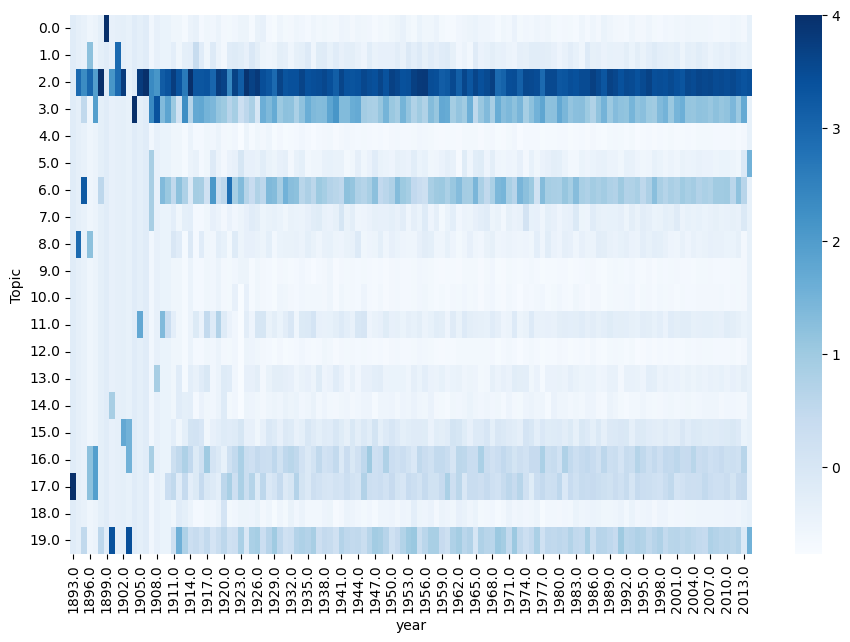

In [30]:
#Create a 2D table with topics as rows and years as columns
for_heatmap_LDA = movies_with_year.groupby(['year','Topic'])['WikiMovieID'].count().reset_index().sort_values(by='year')
for_heatmap_LDA = for_heatmap_LDA.pivot(columns = 'year', index='Topic', values= 'WikiMovieID').fillna(0)

#Row normalization
#cols = for_heatmap_LDA.columns
#for col in cols:
#    for_heatmap_LDA['{}_'.format(col)] = (for_heatmap_LDA[col] - for_heatmap_LDA.mean(axis=1) ) / for_heatmap_LDA.std(axis=1)
#cols_z = ['{}_'.format(col) for col in cols]

#Column normalization
for_heatmap_LDA = (for_heatmap_LDA - for_heatmap_LDA.mean()) / for_heatmap_LDA.std()

fig,ax=plt.subplots(figsize=(11,7))
#sns.heatmap(for_heatmap_LDA[cols_z], ax = ax, yticklabels=True, cmap="Blues", vmax = 5)
sns.heatmap(for_heatmap_LDA, ax = ax, yticklabels=True, cmap="Blues", vmax = 4)

### 1.2.2 With BERT <a id='1.2.2'></a>

<AxesSubplot:xlabel='year', ylabel='BERT_names'>

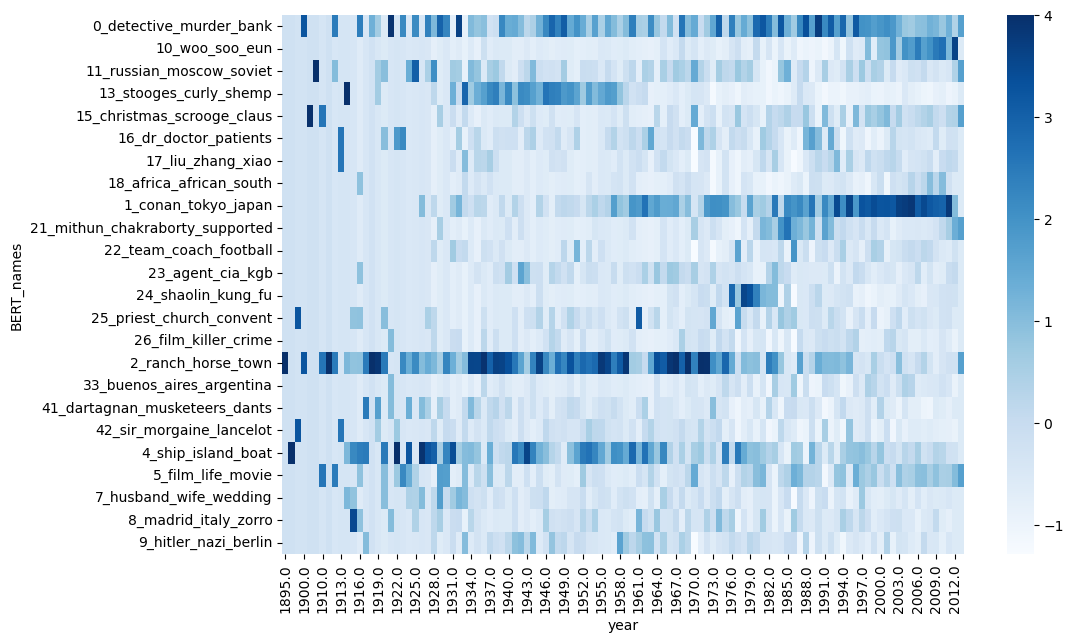

In [31]:
#Create a 2D table with topics as rows and years as columns
for_heatmap_BERT = BERT_movies_with_year.groupby(['year','BERT_names'])['WikiMovieID'].count().reset_index().sort_values(by='year')
for_heatmap_BERT = for_heatmap_BERT.pivot(columns = 'year', index='BERT_names', values= 'WikiMovieID').fillna(0)

#Column normalization
for_heatmap_BERT = (for_heatmap_BERT - for_heatmap_BERT.mean()) / for_heatmap_BERT.std()

fig,ax=plt.subplots(figsize=(11,7))
#sns.heatmap(for_heatmap_LDA[cols_z], ax = ax, yticklabels=True, cmap="Blues", vmax = 5)
sns.heatmap(for_heatmap_BERT, ax = ax, yticklabels=True, cmap="Blues", vmax = 4)

---

# 2. Targeted Topics <a id='2'></a>

## 2.1 The categories <a id='2.1'></a>

### 2.1.1 Creation and description <a id='2.1.1'></a>
The empath tool is used to generate categories of words.  
The model used is reddit, except for war category the model used is nytimes because it gave more accurate words.  
For each categories one to four words are used as lead words to generate a lexical field which links all lead words.  
A maximum size of 200 words per categories is set and the size of the output categories is printed after.

In [2]:
lexicon = Empath()

#### Ecological concern lexical field

In [33]:
lexicon.create_category("ecological_concern", ["ecology", "environment", "climate_change"], model="reddit", size=200)

["ecology", "global_climate_change", "climate_change", "human_activity", "climate", "human_activities", "biodiversity", "environmental_issues", "global_warming", "environment", "changing_climate", "Climate_change", "global_climate", "climate", "human_impact", "ocean_acidification", "climate_changes", "ecosystems", "biosphere", "environmental", "human_development", "climate_science", "environmental_problems", "scientific_research", "human_health", "human_influence", "environmental_impacts", "global_environment", "industrial_agriculture", "animal_agriculture", "rising_temperatures", "fisheries", "agriculture", "genetic_engineering", "environmental_changes", "ecological", "genetic_modification", "resource_depletion", "Global_warming", "environmental_concerns", "human_society", "scientific_consensus", "human_behavior", "weather_patterns", "anthropogenic_climate_change", "modern_agriculture", "natural_cycles", "anthropogenic", "human_survival", "food_system", "overpopulation", "Climate_Chan

In [5]:
len(lexicon.cats["ecological_concern"])

169

### Health concern lexical field

In [16]:
lexicon.create_category("health_concern", ["health", "disease", "pandemics", "medical"], model="reddit", size = 200)

["disease", "diseases", "illnesses", "infectious_diseases", "infectious_disease", "many_diseases", "various_diseases", "other_diseases", "disease", "diseases", "cancers", "other_causes", "epidemics", "other_disease", "most_diseases", "pandemics", "autoimmune_diseases", "chronic_diseases", "many_illnesses", "particular_disease", "serious_diseases", "communicable_diseases", "certain_disease", "serious_disease", "major_diseases", "tuberculosis", "common_cold", "immunosuppression", "certain_diseases", "deadly_diseases", "viral_infection", "other_illnesses", "certain_illnesses", "malaria", "prevention", "specific_disease", "underlying_conditions", "chronic_disease", "other_ailments", "deadly_disease", "illness", "other_conditions", "serious_complications", "immunization", "ailments", "risk_factors", "most_cancers", "serious_illness", "neurological_damage", "genetic_disease", "vaccination", "chemotherapy", "contagious_diseases", "related_conditions", "outbreaks", "viral_infections", "serious

In [17]:
len(lexicon.cats["health_concern"])

168

### War and conflicts concern lexical field

In [45]:
lexicon.create_category("conflict_concern", ["war", "conflict", "nuclear", "immigration"], model="nytimes", size = 200)

["war", "armed_conflict", "warfare", "American_involvement", "terrorism", "nuclear_arms_race", "conflict", "nuclear_proliferation", "American_occupation", "military_power", "drug_war", "guerrilla_war", "arms_race", "insurgency", "American_presence", "superpowers", "military_intervention", "guerrilla_warfare", "American_role", "American_foreign_policy", "international_terrorism", "Iran-Iraq_war", "Islamic_fundamentalism", "long_war", "American_intervention", "cold_war", "military_establishment", "Soviet_threat", "Balkans", "domestic_politics", "occupation", "Soviet_military", "military_conflict", "disarmament", "new_war", "military_forces", "United_States_policy", "political_struggle", "nuclear_war", "the_cold_war", "American_government", "American_policy", "Korean_peninsula", "American_military_presence", "immigration", "extremism", "NATO_alliance", "ethnic_conflict", "political_dialogue", "destabilization", "Arab-Israeli_conflict", "Western_powers", "Israeli-Palestinian_conflict", "ar

In [19]:
len(lexicon.cats["conflict_concern"])

199

### Technologies concern lexical field

In [20]:
lexicon.create_category("technological_concern", ["Artificial_intelligence", "technology", "progress"], model="reddit", size = 200)

["Artificial_intelligence", "technology", "technology", "artificial_intelligence", "strong_AI", "true_AI", "human_technology", "machine_intelligence", "technological_advancement", "AI_technology", "AI_research", "human_intelligence", "new_technology", "advancements", "new_technologies", "computer_technology", "human_ingenuity", "superintelligence", "technological_advances", "future_technology", "advancing_technology", "breakthroughs", "technologies", "technological_progress", "Strong_AI", "nanotechnology", "technological_advancements", "space_travel", "current_technology", "technological_singularity", "super-intelligence", "complex_systems", "Advances", "AI_development", "future_technologies", "Advancements", "great_technology", "virtual_reality", "revolutionary_technology", "A.I.", "Artificial_Intelligence", "human_intellect", "technological_development", "other_technologies", "technological", "quantum_computing", "space_colonization", "such_technology", "information_age", "advanced_A

In [21]:
len(lexicon.cats["technological_concern"])

172

In [17]:
lexicon.create_category("space_concern", ["space", "planet", "exploration"], model="reddit", size = 200)

["space", "planet", "planet", "outer_space", "deep_space", "space", "spaceship", "solar_system", "other_planets", "multiple_planets", "entire_solar_system", "new_planet", "outerspace", "space_station", "mars", "whole_planet", "space_ship", "own_planet", "terraforming", "space_travel", "other_planet", "celestial_body", "interstellar_space", "alien_planet", "space_stations", "entire_planet", "single_planet", "Earth", "terraforming", "dead_planet", "Solar_System", "habitable_planet", "Mars", "space_craft", "planet_Earth", "biosphere", "Earth", "earth", "other_worlds", "interplanetary", "spaceships", "planetary_system", "whole_solar_system", "asteroid", "entire_planets", "interstellar_travel", "biosphere", "asteroid_belt", "interplanetary_travel", "Solar_system", "Solar_System", "several_planets", "many_planets", "entire_galaxy", "solar_systems", "new_frontiers", "warp_travel", "colony_ships", "wormhole", "space_colonies", "distant_planet", "asteroids", "exploration", "earth_orbit", "life_

In [22]:
len(lexicon.cats["space_concern"])

160

### Gender inequalities concern lexical field

In [22]:
lexicon.create_category("gender_inequality_concern", ["gender_inequality", "misoginy", "sexism", "domestic_violence"], model="reddit", size = 200)

["sexism", "misogyny", "rape_culture", "gender_inequality", "toxic_masculinity", "misandry", "misogyny", "misandry", "misogyny", "homophobia", "sexual_objectification", "victimization", "transphobia", "institutional_sexism", "slut-shaming", "Sexism", "blatant_sexism", "feminism", "male_rape", "slut_shaming", "racism", "feminist_movement", "mysogyny", "transmisogyny", "feminists", "male_rape_victims", "patriarchy", "objectification", "modern_feminism", "gender_issue", "benevolent_sexism", "male_privilege", "male_victims", "gendered_violence", "actual_sexism", "trivialization", "gender_bias", "prison_rape", "microaggressions", "rape_hysteria", "many_feminists", "sexual_violence", "social_injustice", "classism", "domestic_abuse", "systemic_oppression", "domestic_violence", "casual_sexism", "systematic_oppression", "feminist_issue", "Misogyny", "microagressions", "rampant_sexism", "gendered_issue", "feminist_issues", "racism/sexism", "third_wave_feminism", "gender_equality", "marginalizati

In [23]:
len(lexicon.cats["gender_inequality_concern"])

179

### LBGQT+ and Homophobia concern lexical field


In [24]:
lexicon.create_category("homophobia_concern", ["lgbt", "homophobia", "gender"], model="reddit", size = 200)

["homophobia", "homosexual_people", "transgenders", "LGBT", "sexual_minorities", "lgbt", "transgendered_people", "LGBT_people", "discrimination", "transpeople", "transphobia", "sexism", "prejudice", "queer_people", "gender", "LGBT_community", "transgender_people", "sexual_preference", "trans_folk", "bigotry", "trans_people", "bigoted", "sexual_orientation", "transexuals", "lgbt_community", "sexual_orientations", "gay_people", "transgender", "transmisogyny", "lgbt_people", "LGBTQ_people", "misogyny", "transsexuals", "LGBTQ_community", "LGBTQ", "racism", "stereotyping", "queer", "marginalized_group", "racial_minorities", "biphobia", "transgendered", "trans", "trans_community", "sexuality", "gay_community", "LGBT_folk", "minority_groups", "oppressed_group", "feminism", "heterosexism", "LGBT", "sexualities", "minority_group", "heterosexual_people", "LGBT", "anti-racism", "sexual_minority", "straight_people", "sexual_identity", "misandry", "feminists", "gender_identity", "sexual_preferences

In [25]:
len(lexicon.cats["homophobia_concern"])

177

### Racism concern lexical field

In [26]:
lexicon.create_category("racism_concern", ["racism"], model="reddit", size = 200)

["racism", "actual_racism", "institutional_racism", "bigotry", "prejudice", "racial_prejudice", "xenophobia", "classism", "homophobia", "real_racism", "white_supremacy", "systemic_racism", "institutionalized_racism", "Racism", "blatant_racism", "sexism", "systematic_racism", "stereotyping", "racism/sexism", "systematic_oppression", "overt_racism", "white_racism", "reverse_racism", "systemic_oppression", "oppression", "just_racism", "anti-white_racism", "anti-black_racism", "casual_racism", "misogyny", "islamophobia", "white_privilege", "rampant_racism", "white_guilt", "racial_bigotry", "inherent_racism", "institutionalized_oppression", "racisim", "rascism", "Islamophobia", "marginalization", "racial_oppression", "social_injustice", "structural_racism", "racial_discrimination", "ethnocentrism", "race_issues", "religious_intolerance", "racial_stereotyping", "discrimination", "anti-semitism", "white_oppression", "white_culture", "chauvinism", "transphobia", "political_correctness", "anti-

In [27]:
len(lexicon.cats["racism_concern"])

174

### Mental concern lexical field

In [28]:
lexicon.create_category("mental_concern", ["mental", "mental_health"], model="reddit", size = 200)

["mental_issues", "mental_health", "mental_health_problems", "mental_problems", "severe_mental_illness", "mental_wellbeing", "mental_condition", "mental_health_issues", "mental_health_issue", "psychological_issues", "mental_illness", "mental_stability", "mental", "psychological_problems", "anger_issues", "mental_and_physical_health", "mental_state", "mental_well-being", "mental_disorder", "physical_health", "mental_issue", "psychological_condition", "depression", "lifestyle_habits", "psychiatric_problems", "mental_illnesses", "psychological_disorder", "serious_mental_illness", "underlying_issues", "mental_disorders", "mental_health_problem", "destructive_behaviors", "clinical_depression", "emotional_stability", "psychological_health", "physical_problems", "emotional_issues", "mental_disease", "mental_health_conditions", "anxiety_problems", "anxiety/depression", "disorder", "own_mental_health", "chronic_depression", "mental_conditions", "health_problem", "neurosis", "very_serious_issue"

In [29]:
len(lexicon.cats["mental_concern"])

174

### Human interactions and relationships concern lexical field

In [30]:
lexicon.create_category("relationships_concern", ["interaction", "relationshps", "family"], model="reddit", size = 200)

["family", "interaction", "family_life", "positive_relationship", "family_relationships", "family", "personal_relationships", "relationship", "intimate_relationships", "relationships", "own_family", "own_relationship", "romantic_life", "home_life", "family_&amp", "interactions", "love_life", "friendship", "own_friends", "significant_others", "friendships", "social_ties", "emotional_support", "intimate_relationship", "important_way", "family_unit", "shared_experience", "closest_people", "family/friends", "social_connections", "close_relationships", "estrangement", "personal_life", "social_connection", "confiding", "family_members", "even_family", "social_contact", "well-being", "loved_ones", "_family", "emotional_well-being", "realtionship", "loving_relationship", "partner", "feelings", "social_interactions", "lives", "other_relationships", "support_network", "own_life", "family-", "emotional_investment", "emotional_wellbeing", "social_function", "emotional_state", "affection", "family_

In [31]:
len(lexicon.cats["relationships_concern"])

182

For this analysis, we need to add all possible bigrams, to not do lemmatization nor casefolding. 
Thus we create an additional column with the tokens from plot summaries but preprocessed in a different ways as we did in Milestone2.

Read last movies dataset and create the column to use for empath analysis

In [6]:
movies = pd.read_pickle('data/movies_aug_bert+SA.pkl')

In [7]:
movies['for_Empath'] = movies['tokens_sentences'].progress_apply(lambda sentences: list(chain.from_iterable(sentences)))

100%|█████████████████████████████████████████████████████████████████████████| 42178/42178 [00:00<00:00, 88950.38it/s]


Keep token if not present in stopwords, if not a number and if has more than one letter

In [8]:
movies['for_Empath'] = movies['for_Empath'].progress_apply(lambda tokens: [token for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english') and len(token)>1])

100%|████████████████████████████████████████████████████████████████████████████| 42178/42178 [31:59<00:00, 21.98it/s]


Remove character names (not useful in categories lexical fields)

In [14]:
nd = NameDataset()
names = nd.get_top_names(n=2000, country_alpha2="US")
names = names["US"]["M"] + names["US"]["F"]
names = [name.lower() for name in names]

In [15]:
movies['for_Empath'] = movies['for_Empath'].progress_apply(lambda tokens: [token for token in tokens if token.lower() not in names])

100%|███████████████████████████████████████████████████████████████████████████| 42178/42178 [03:29<00:00, 201.28it/s]


Create bigrams and add them to the list of tokens

In [18]:
bigram_model = Phrases(movies.for_Empath, min_count=1)

In [19]:
def add_bigrams(row):
    for tok in bigram_model[row]:
        if '_' in tok:
            row.append(tok)
    return row

In [20]:
movies['for_Empath'] = movies['for_Empath'].apply(lambda row: add_bigrams(row))

### 2.1.2 Distribution analysis <a id='2.1.2'></a>

Add score for each categories to movies dataset  
The scores are normalized over the words in the plot summary

In [50]:
def find_score_category(row, category):
    dic = lexicon.analyze(row, categories=[category], normalize=True)
    score = dic[category]
    return score

In [51]:
categories = ["ecological_concern", "health_concern", "conflict_concern", "technological_concern",
              "space_concern", "gender_inequality_concern", "homophobia_concern", "racism_concern",
              "mental_concern", "relationships_concern"]
for category in categories :
    movies[category] = movies["for_Empath"].apply(lambda row: find_score_category(row, category))

In [137]:
movies.to_pickle('movies_for_empath.pkl')

#### Visualize results

Look for percentage of movies that are in a certain category
- first by count all non-null entries for each categories
- then by restricting to only movies having a score greater than 0.01

In [118]:
def count_movies_category(category, threshold):
    count = np.sum(movies[category].values>threshold)
    return count

In [119]:
non_null = []
for category in categories :
    non_null.append(100 * count_movies_category(category, threshold=0) / len(movies))
high_score = []
for category in categories :
    high_score.append(100 * count_movies_category(category, threshold=0.01) / len(movies))

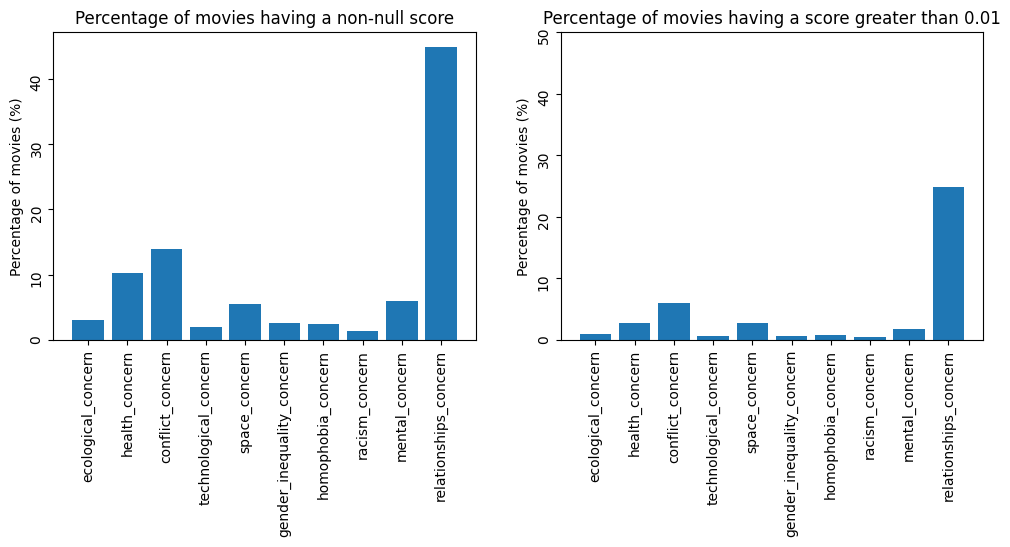

In [139]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].bar(categories, non_null)
axs[0].tick_params(labelrotation=90)
axs[1].set_ylim([0, 50])
axs[0].set_ylabel("Percentage of movies (%)")
axs[0].set_title("Percentage of movies having a non-null score")
axs[1].bar(categories, high_score)
axs[1].tick_params(labelrotation=90)
axs[1].set_ylim([0, 50])
axs[1].set_ylabel("Percentage of movies (%)")
axs[1].set_title("Percentage of movies having a score greater than 0.01")
plt.show()

## 2.2 Categories over time<a id='2.2'></a>

---

# 3. Sentiments <a id='3'></a>

## 3.1 The sentiments <a id='3.1'></a>

### 3.1.1 Plot sentiment analysis <a id='3.1.1'></a>

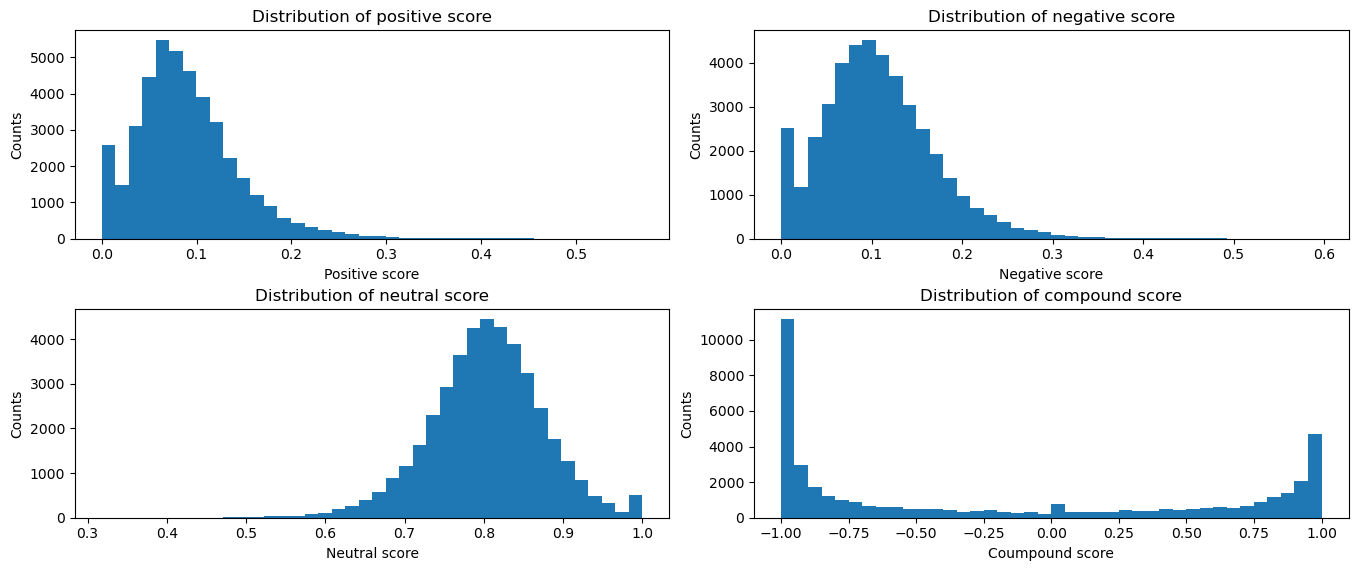

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.positive_score,bins=40)
axs[0,0].set_title('Distribution of positive score')
axs[0,0].set_xlabel('Positive score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.negative_score,bins=40)
axs[0,1].set_title('Distribution of negative score')
axs[0,1].set_xlabel('Negative score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.neutral_score,bins=40)
axs[1,0].set_title('Distribution of neutral score')
axs[1,0].set_xlabel('Neutral score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.compound_score,bins=40)
axs[1,1].set_title('Distribution of compound score')
axs[1,1].set_xlabel('Coumpound score')
axs[1,1].set_ylabel('Counts')

plt.show()

### 3.1.2 Plot multi-sentiments <a id='3.1.2'></a>

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

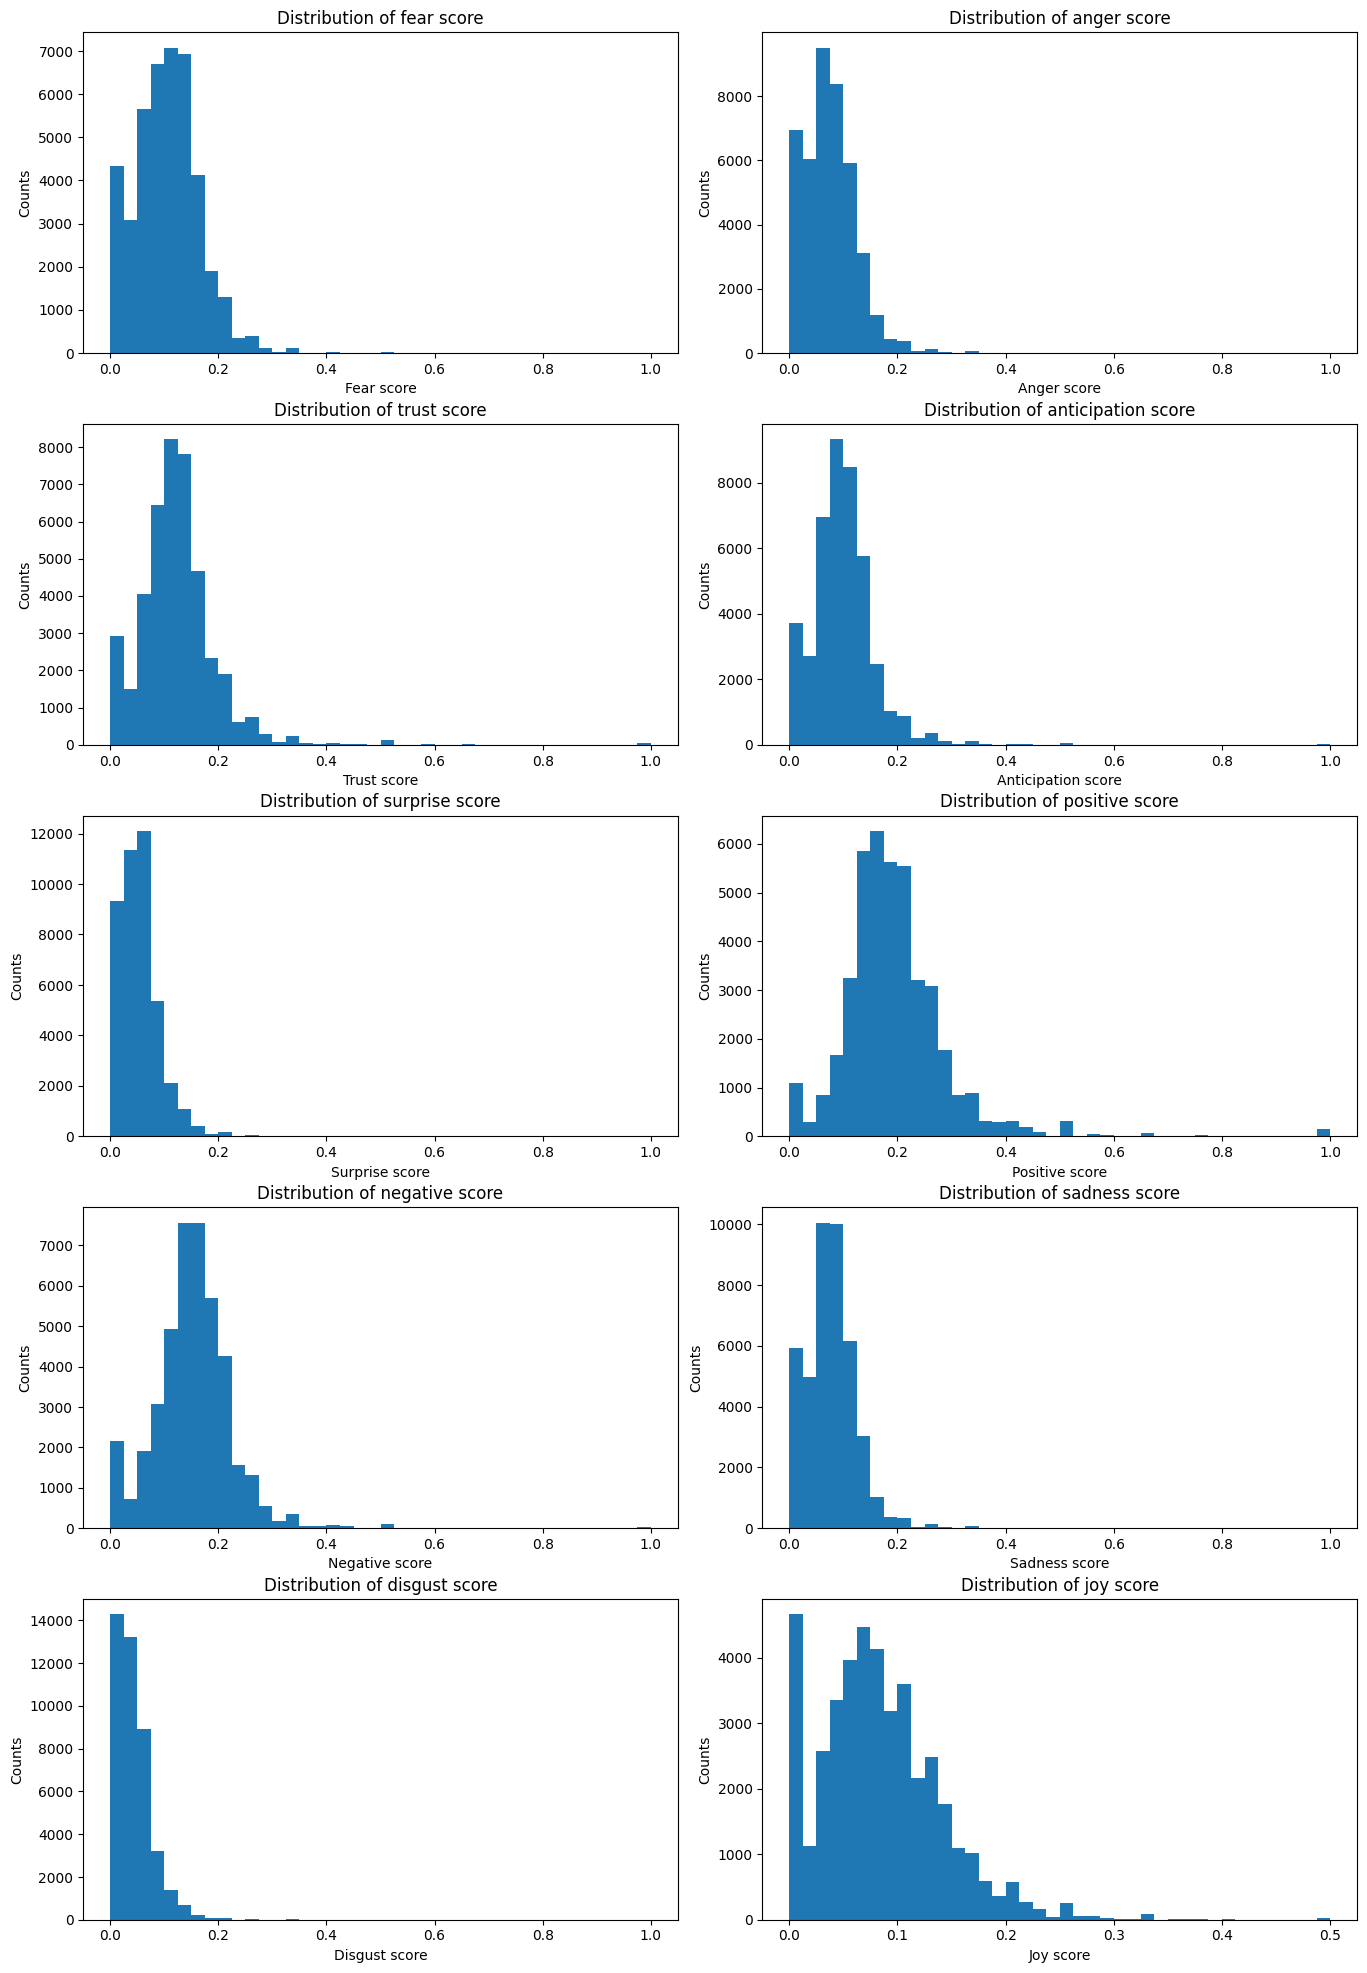

In [56]:
fig, axs = plt.subplots(5, 2, figsize=(14,20))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['fear']),bins=40)
axs[0,0].set_title('Distribution of fear score')
axs[0,0].set_xlabel('Fear score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anger']),bins=40)
axs[0,1].set_title('Distribution of anger score')
axs[0,1].set_xlabel('Anger score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['trust']),bins=40)
axs[1,0].set_title('Distribution of trust score')
axs[1,0].set_xlabel('Trust score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anticipation'] if 'anticipation' in score_dict else 0),bins=40)
axs[1,1].set_title('Distribution of anticipation score')
axs[1,1].set_xlabel('Anticipation score')
axs[1,1].set_ylabel('Counts')

axs[2,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['surprise']),bins=40)
axs[2,0].set_title('Distribution of surprise score')
axs[2,0].set_xlabel('Surprise score')
axs[2,0].set_ylabel('Counts')

axs[2,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['positive']),bins=40)
axs[2,1].set_title('Distribution of positive score')
axs[2,1].set_xlabel('Positive score')
axs[2,1].set_ylabel('Counts')

axs[3,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['negative']),bins=40)
axs[3,0].set_title('Distribution of negative score')
axs[3,0].set_xlabel('Negative score')
axs[3,0].set_ylabel('Counts')

axs[3,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['sadness']),bins=40)
axs[3,1].set_title('Distribution of sadness score')
axs[3,1].set_xlabel('Sadness score')
axs[3,1].set_ylabel('Counts')

axs[4,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['disgust']),bins=40)
axs[4,0].set_title('Distribution of disgust score')
axs[4,0].set_xlabel('Disgust score')
axs[4,0].set_ylabel('Counts')

axs[4,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['joy']),bins=40)
axs[4,1].set_title('Distribution of joy score')
axs[4,1].set_xlabel('Joy score')
axs[4,1].set_ylabel('Counts')


plt.show()

## 2.2 Sentiments over time <a id='2.2'></a>

In [7]:
movies.head()

WikiMovieID FreeMovieID                      Title ReleaseDate     Revenue  \
0       975900   /m/03vyhn             Ghosts of Mars  2001-08-24  14010832.0   
1      9363483  /m/0285_cd           White Of The Eye        1987         NaN   
2       261236   /m/01mrr1          A Woman in Flames        1983         NaN   
3     18998739  /m/04jcqvw  The Sorcerer's Apprentice        2002         NaN   
4      6631279   /m/0gffwj                Little city  1997-04-04         NaN   

   Runtime           Languages                   Countries  \
0     98.0  [English Language]  [United States of America]   
1    110.0  [English Language]            [United Kingdom]   
2    106.0   [German Language]                   [Germany]   
3     86.0  [English Language]              [South Africa]   
4     93.0  [English Language]  [United States of America]   

                                              Genres  \
0  [Thriller, Science Fiction, Horror, Adventure,...   
1  [Thriller, Erotic thriller, Psychological thri...   
2                                            [Drama]   
3    [Family Film, Fantasy, Adventure, World cinema]   
4  [Romantic comedy, Ensemble Film, Comedy-drama,...   

                                                Plot  ... Topic BERT  \
0  Set in the second half of the 22nd century, th...  ...   1.0   -1   
1  A series of murders of rich young women throug...  ...   2.0    0   
2  Eva, an upper class housewife, becomes frustra...  ...   5.0   -1   
3  Every hundred years, the evil Morgana  returns...  ...   6.0   -1   
4  Adam, a San Francisco-based artist who works a...  ...   2.0   -1   

                                              scores positive_score  \
0  {'neg': 0.15, 'neu': 0.786, 'pos': 0.065, 'com...          0.065   
1  {'neg': 0.197, 'neu': 0.718, 'pos': 0.085, 'co...          0.085   
2  {'neg': 0.065, 'neu': 0.835, 'pos': 0.1, 'comp...          0.100   
3  {'neg': 0.131, 'neu': 0.776, 'pos': 0.092, 'co...          0.092   
4  {'neg': 0.108, 'neu': 0.804, 'pos': 0.089, 'co...          0.089   

  negative_score neutral_score compound_score  \
0          0.150         0.786        -0.9913   
1          0.197         0.718        -0.9983   
2          0.065         0.835         0.9604   
3          0.131         0.776        -0.8885   
4          0.108         0.804        -0.7097   

                                        multi_scores    year  five_year_period  
0  {'fear': 0.16296296296296298, 'anger': 0.13333...  2001.0            2000.0  
1  {'fear': 0.1751412429378531, 'anger': 0.135593...  1987.0            1985.0  
2  {'fear': 0.0673076923076923, 'anger': 0.105769...  1983.0            1980.0  
3  {'fear': 0.08163265306122448, 'anger': 0.12244...  2002.0            2000.0  
4  {'fear': 0.07317073170731707, 'anger': 0.04878...  1997.0            1995.0  

[5 rows x 43 columns]

In [18]:
movies_with_year.groupby(["year"])['positive_score']

In [19]:
movies_with_year.groupby(["year"])['positive_score'].mean()

year
1893.0    0.000000
1894.0    0.128000
1895.0    0.033889
1896.0    0.044167
1897.0    0.040250
            ...   
2010.0    0.089646
2011.0    0.093695
2012.0    0.099331
2013.0    0.098271
2014.0    0.086000
Name: positive_score, Length: 122, dtype: float64

In [68]:
np.sort(movies_with_year["year"].unique())

array([1893., 1894., 1895., 1896., 1897., 1898., 1899., 1900., 1901.,
       1902., 1903., 1904., 1905., 1906., 1907., 1908., 1909., 1910.,
       1911., 1912., 1913., 1914., 1915., 1916., 1917., 1918., 1919.,
       1920., 1921., 1922., 1923., 1924., 1925., 1926., 1927., 1928.,
       1929., 1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937.,
       1938., 1939., 1940., 1941., 1942., 1943., 1944., 1945., 1946.,
       1947., 1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955.,
       1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014.])

In [30]:
movies_with_year['positive_score'].isna().sum()

0

In [109]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [127]:
bootstrap_CIs_1year = {}
sentiments_SA = ['positive', 'negative', 'neutral', 'compound']
multi_sentiments=['fear','anger','trust','surprise','sadness','disgust','joy','anticipation']

for key in sentiments_SA:
    bootstrap_CIs_1year['Lower_{}'.format(key)]=[]
    bootstrap_CIs_1year['Upper_{}'.format(key)]=[]
for key in multi_sentiments:
    bootstrap_CIs_1year['Lower_{}'.format(key)]=[]
    bootstrap_CIs_1year['Upper_{}'.format(key)]=[]
    
for group_name, group in movies_with_year.groupby(["year"]):
    for key in sentiments_SA:
        bootstrap_CIs_1year['Lower_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[0])
        bootstrap_CIs_1year['Upper_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[1])
    for key_ in multi_sentiments:
        bootstrap_CIs_1year['Lower_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[0])
        bootstrap_CIs_1year['Upper_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[1])


/var/folders/8x/2ggqc7_j2m57wss0wl9ckm1h0000gn/T/ipykernel_5214/3218706822.py:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group in movies_with_year.groupby(["year"]):


In [128]:
bootstrap_CIs_1year['Lower_positive'][:10]

[0.0,
 0.113,
 0.005555555555555556,
 0.007,
 0.01225,
 0.009275,
 0.021,
 0.042333333333333334,
 0.06,
 0.0]

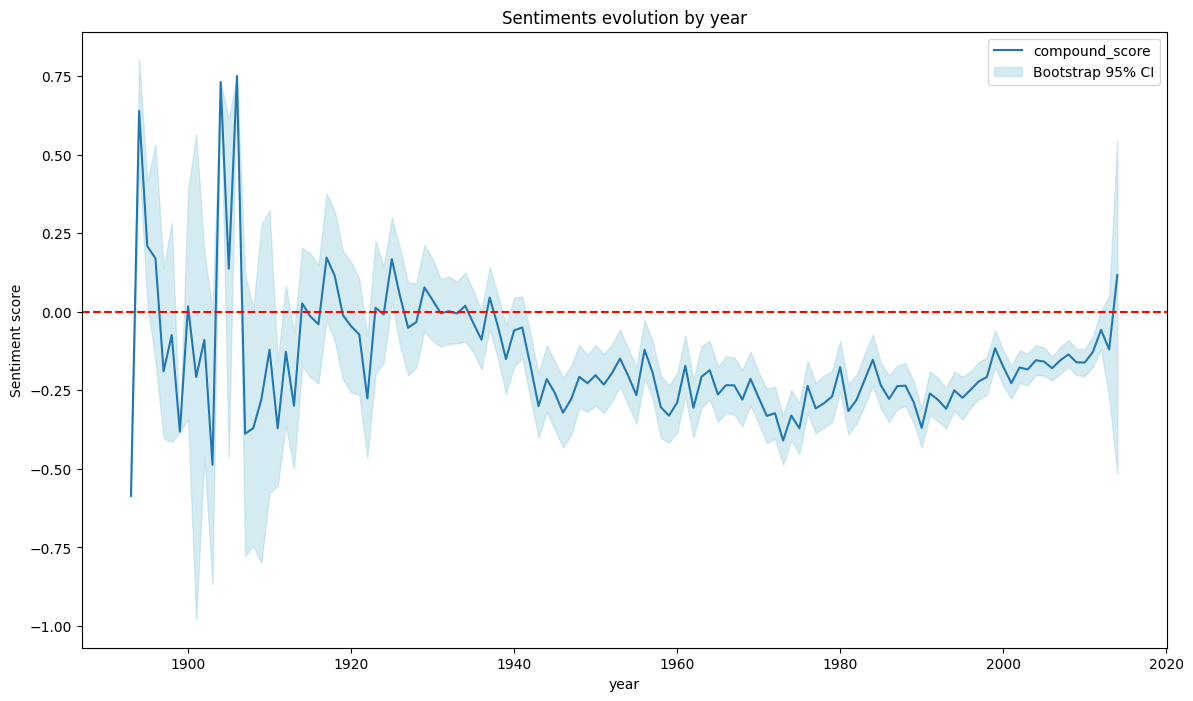

In [160]:
# PLot of SA over time (years)

fig = plt.figure(figsize=(14,8))
#Means
temp = movies_with_year.groupby(["year"])['compound_score'].mean()
fig = temp.plot()
fig = plt.axhline(y=0,color='red',linestyle='--')

#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_compound'],bootstrap_CIs_1year['Upper_compound'], alpha = 0.5, color = 'lightblue', label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by year")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

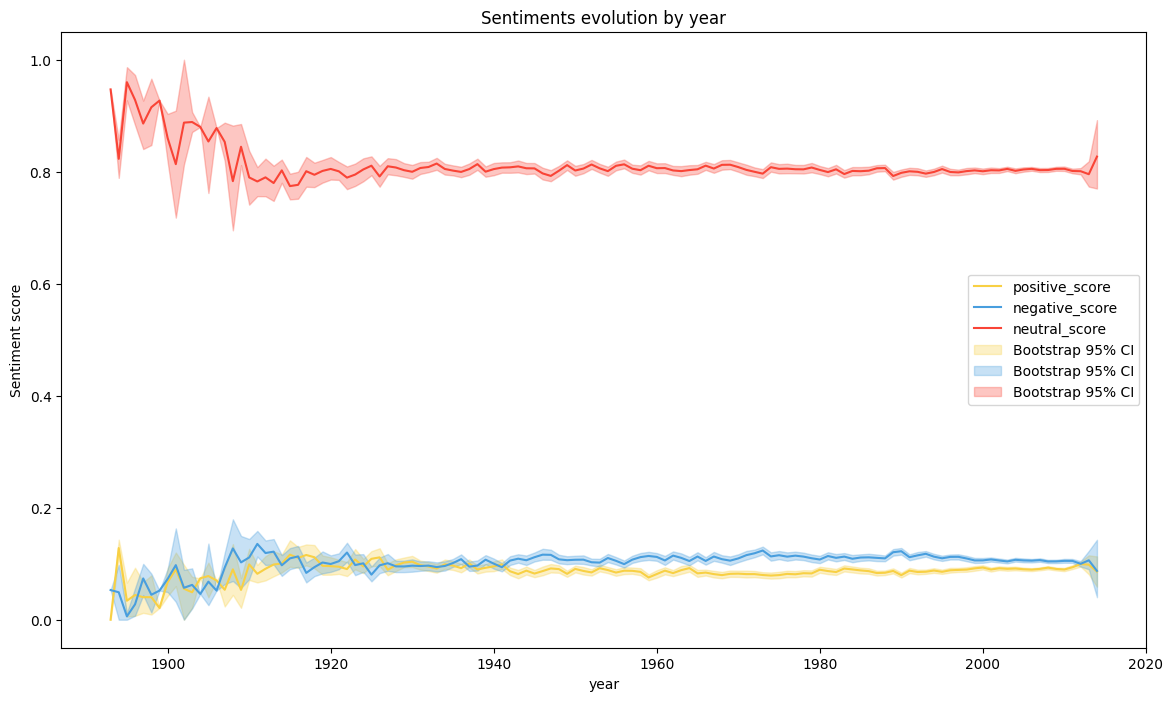

In [161]:
# PLot of SA over time (years)

fig = plt.figure(figsize=(14,8))
#Mans
temp = movies_with_year.groupby(["year"])['positive_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["year"])['negative_score'].mean()
fig = temp.plot(color='#489ede')
temp = movies_with_year.groupby(["year"])['neutral_score'].mean()
fig = temp.plot(color='#f94436')


#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_positive'],bootstrap_CIs_1year['Upper_positive'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_negative'],bootstrap_CIs_1year['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_neutral'],bootstrap_CIs_1year['Upper_neutral'], alpha = 0.3, color = '#f94436',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by year")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

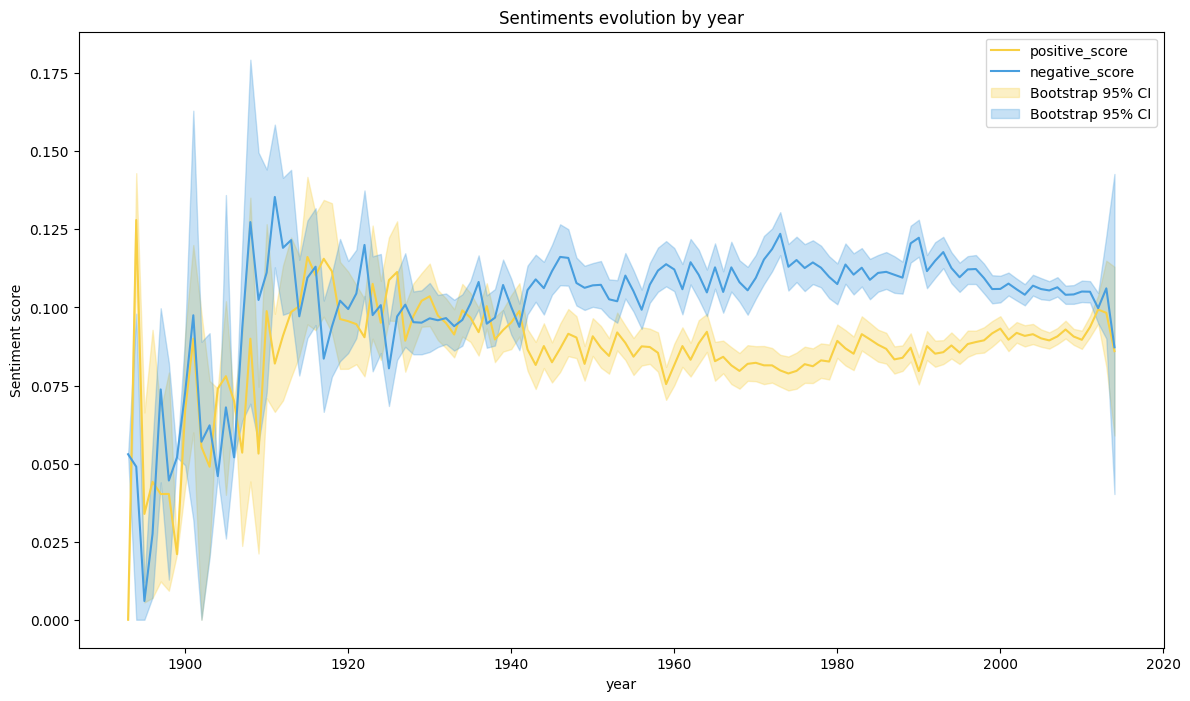

In [162]:
# PLot of SA over time (years)

fig = plt.figure(figsize=(14,8))
temp = movies_with_year.groupby(["year"])['positive_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["year"])['negative_score'].mean()
fig = temp.plot(color='#489ede')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_positive'],bootstrap_CIs_1year['Upper_positive'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_negative'],bootstrap_CIs_1year['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by year")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

In [ ]:
movies_with_year.groupby(["year"]).indices #returns a dict of the indices for each year

In [137]:
multi_sentiments_color_dict={'fear':'#f94436','anger':'#8c3214','trust':'#f8d044','surprise':'#f28b0c',
                             'sadness':'#44c2f8','disgust':'#6ab867','joy':'#de489f','anticipation':'#489ede'}

multi_sentiments_color_dict['fear']

'#f94436'

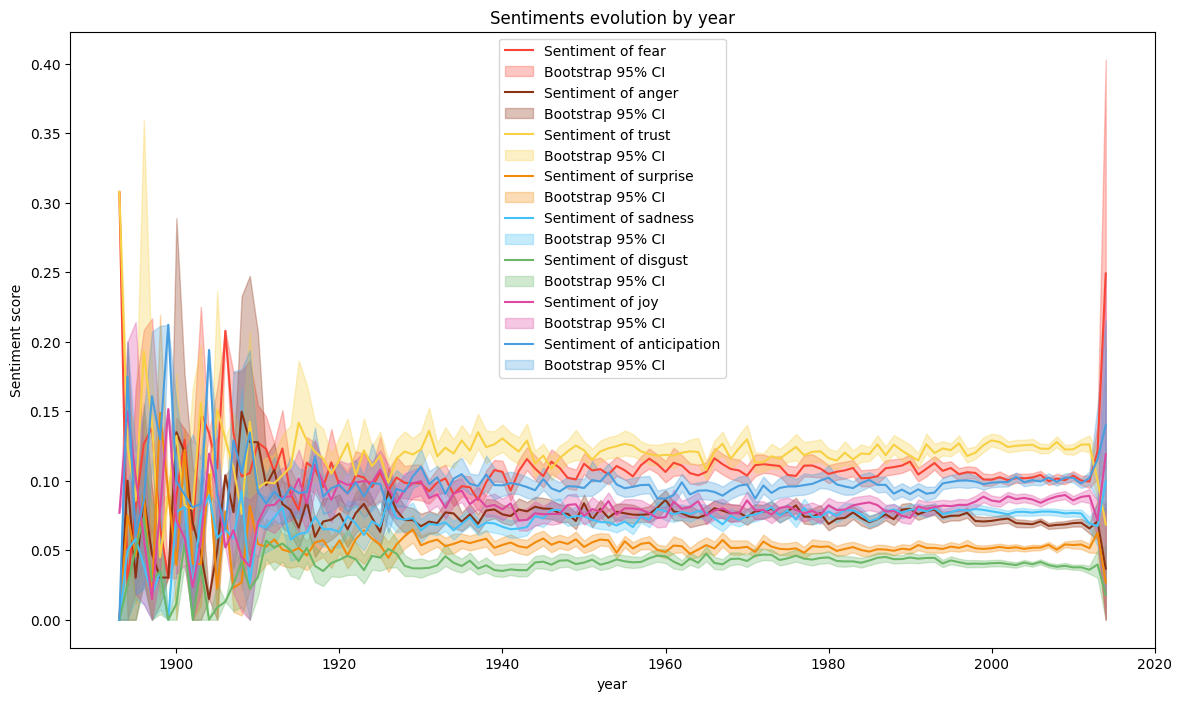

In [163]:
# PLot of multi SA over time (years)
multi_sentiments_color_dict={'fear':'#f94436','anger':'#8c3214','trust':'#f8d044','surprise':'#f28b0c',
                             'sadness':'#44c2f8','disgust':'#6ab867','joy':'#de489f','anticipation':'#489ede'}
fig = plt.figure(figsize=(14,8))

for key in multi_sentiments:
    temp = movies_with_year.groupby(["year"])['multi_{}'.format(key)].mean()
    fig = temp.plot(label='Sentiment of {}'.format(key), color=multi_sentiments_color_dict['{}'.format(key)])
    fig = plt.fill_between(np.sort(movies_with_year["year"].unique()),bootstrap_CIs_1year['Lower_{}'.format(key)],bootstrap_CIs_1year['Upper_{}'.format(key)], alpha = 0.3, color=multi_sentiments_color_dict['{}'.format(key)],label='Bootstrap 95% CI')
    
#fig = plt.fill_between(
fig = plt.title("Sentiments evolution by year")
fig = plt.ylabel('Sentiment score')
fig = plt.legend(loc='upper center')
fig = plt.show()

In [147]:
bootstrap_CIs_5years = {}

for key in sentiments_SA:
    bootstrap_CIs_5years['Lower_{}'.format(key)]=[]
    bootstrap_CIs_5years['Upper_{}'.format(key)]=[]
for key in multi_sentiments:
    bootstrap_CIs_5years['Lower_{}'.format(key)]=[]
    bootstrap_CIs_5years['Upper_{}'.format(key)]=[]
    
for group_name, group in movies_with_year.groupby(["five_year_period"]):
    for key in sentiments_SA:
        bootstrap_CIs_5years['Lower_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[0])
        bootstrap_CIs_5years['Upper_{}'.format(key)].append(bootstrap_CI(group['{}_score'.format(key)],1000)[1])
    for key_ in multi_sentiments:
        bootstrap_CIs_5years['Lower_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[0])
        bootstrap_CIs_5years['Upper_{}'.format(key_)].append(bootstrap_CI(group['multi_{}'.format(key_)],1000)[1])



/var/folders/8x/2ggqc7_j2m57wss0wl9ckm1h0000gn/T/ipykernel_5214/3947321001.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group in movies_with_year.groupby(["five_year_period"]):


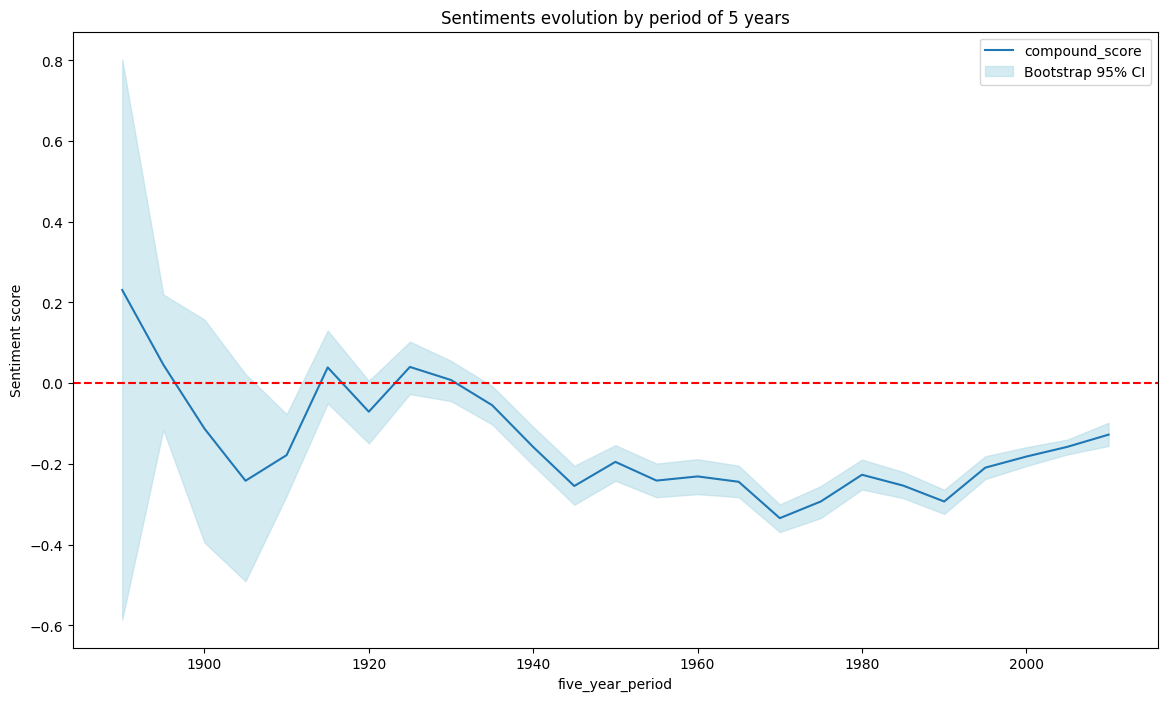

In [164]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
#Means
temp = movies_with_year.groupby(["five_year_period"])['compound_score'].mean()
fig = temp.plot()
fig = plt.axhline(y=0,color='red',linestyle='--')

#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_compound'],bootstrap_CIs_5years['Upper_compound'], alpha = 0.5, color = 'lightblue',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

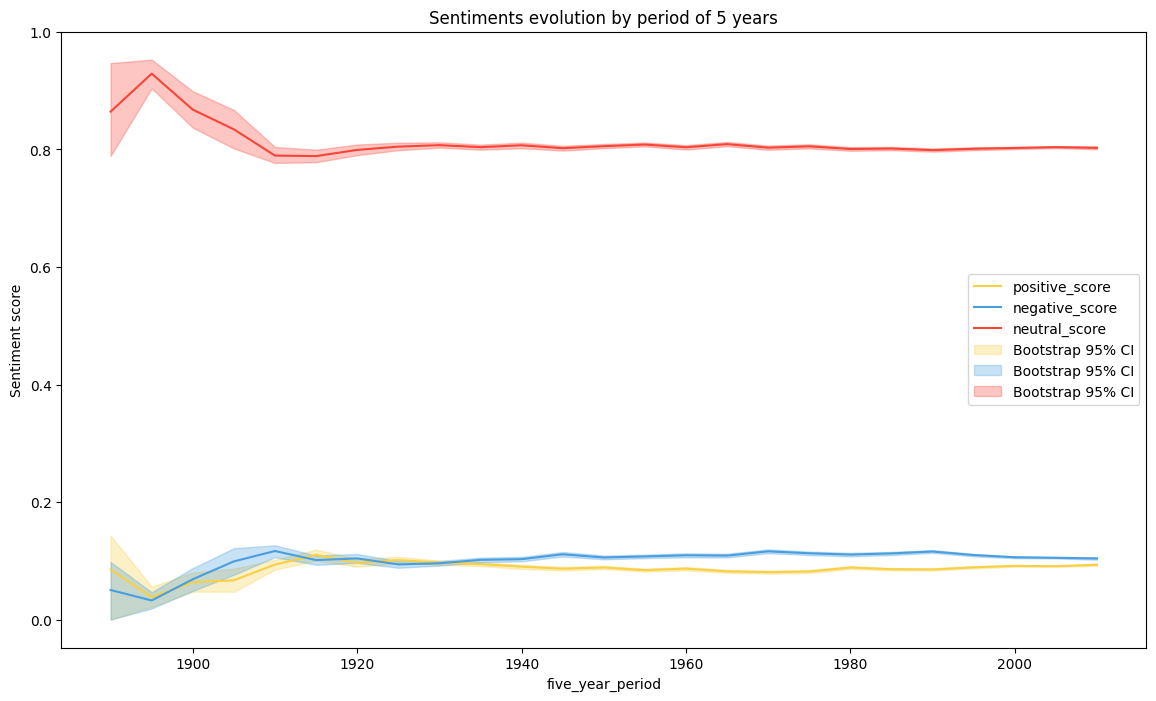

In [165]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
#Mans
temp = movies_with_year.groupby(["five_year_period"])['positive_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["five_year_period"])['negative_score'].mean()
fig = temp.plot(color='#489ede')
temp = movies_with_year.groupby(["five_year_period"])['neutral_score'].mean()
fig = temp.plot(color='#f94436')


#Boostrap CIs for the mean scores
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_positive'],bootstrap_CIs_5years['Upper_positive'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_negative'],bootstrap_CIs_5years['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_neutral'],bootstrap_CIs_5years['Upper_neutral'], alpha = 0.3, color = '#f94436',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

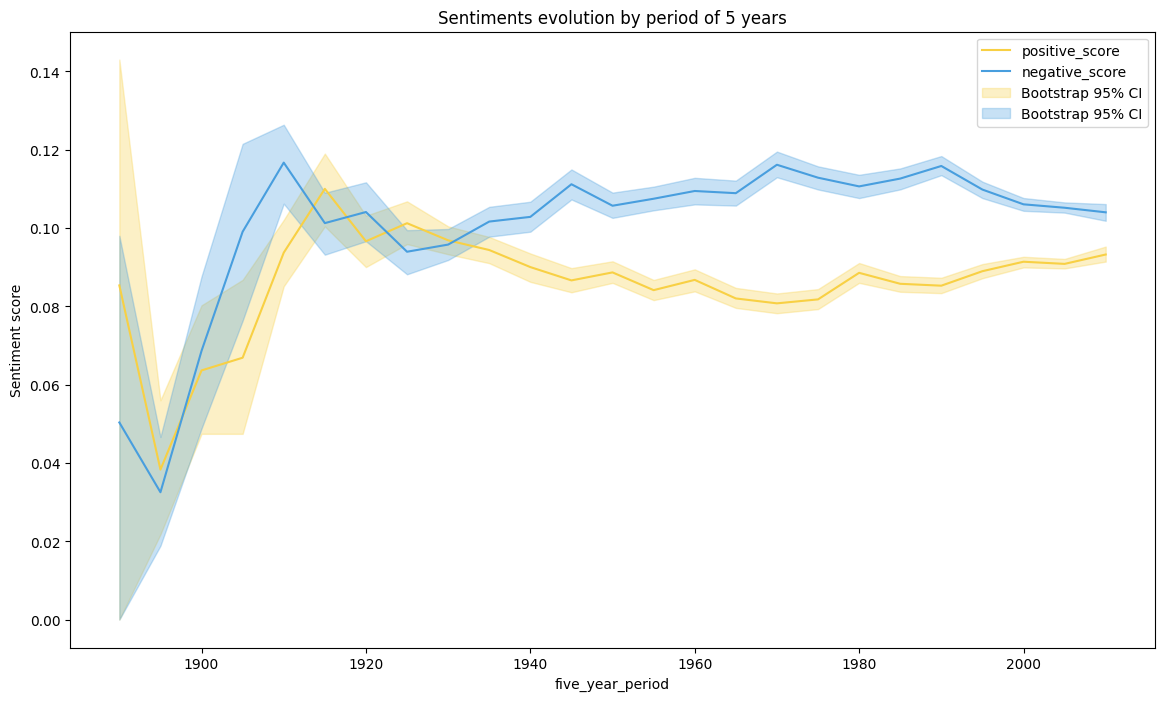

In [166]:
# PLot of SA over time (5years)

fig = plt.figure(figsize=(14,8))
temp = movies_with_year.groupby(["five_year_period"])['positive_score'].mean()
fig = temp.plot(color='#f8d044')
temp = movies_with_year.groupby(["five_year_period"])['negative_score'].mean()
fig = temp.plot(color='#489ede')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_positive'],bootstrap_CIs_5years['Upper_positive'], alpha = 0.3, color = '#f8d044',label='Bootstrap 95% CI')
fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_negative'],bootstrap_CIs_5years['Upper_negative'], alpha = 0.3, color = '#489ede',label='Bootstrap 95% CI')

fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend()
fig = plt.show()

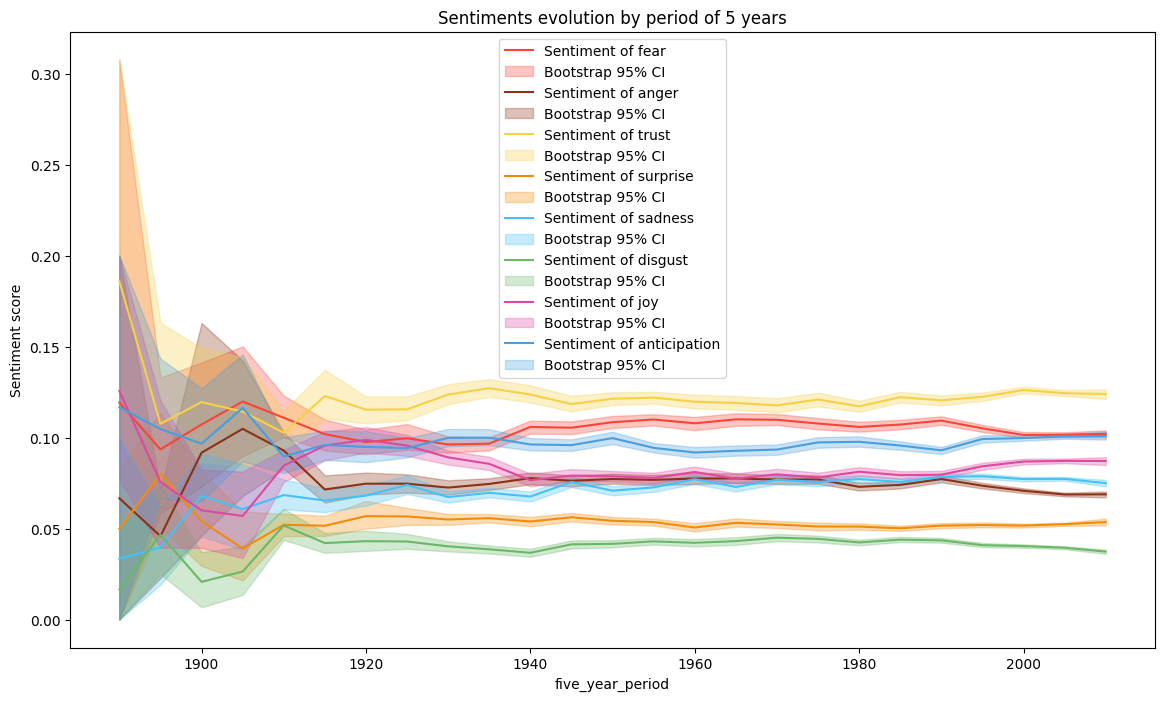

In [167]:
# PLot of multi SA over time (years)
fig = plt.figure(figsize=(14,8))

for key in multi_sentiments:
    temp = movies_with_year.groupby(["five_year_period"])['multi_{}'.format(key)].mean()
    fig = temp.plot(label='Sentiment of {}'.format(key), color=multi_sentiments_color_dict['{}'.format(key)])
    fig = plt.fill_between(np.sort(movies_with_year["five_year_period"].unique()),bootstrap_CIs_5years['Lower_{}'.format(key)],bootstrap_CIs_5years['Upper_{}'.format(key)], alpha = 0.3, color=multi_sentiments_color_dict['{}'.format(key)],label='Bootstrap 95% CI')
    
#fig = plt.fill_between(
fig = plt.title("Sentiments evolution by period of 5 years")
fig = plt.ylabel('Sentiment score')
fig = plt.legend(loc='upper center')
fig = plt.show()

---

# 4. Combined <a id='4'></a>

## 4.1 Topics and sentiments <a id='4.1'></a>

In [66]:
#Compute the mean for each topic
topics_BERT=bert_topics.head(20).index.tolist()

temp = pd.DataFrame(columns = ['positive', 'negative', 'neutral', 'fear', 'anger', 'anticip', 'trust', 'surprise','positive_multi',
                               'negative_multi','sadness','disgust','joy','anticipation'], 
                   index = topics_BERT)
for topic in topics_BERT:
    #SA
    temp.at[topic,'positive'] = np.mean(movies[movies['BERT']==topic].positive_score)
    temp.at[topic,'negative'] = np.mean(movies[movies['BERT']==topic].negative_score)
    temp.at[topic,'neutral'] = np.mean(movies[movies['BERT']==topic].neutral_score)
    
    #Multi SA
    temp.at[topic,'fear'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['fear']))
    temp.at[topic,'anticip'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticip']))
    temp.at[topic,'trust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['trust']))
    temp.at[topic,'surprise'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['surprise']))
    temp.at[topic,'positive_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['positive']))
    temp.at[topic,'negative_multi'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['negative']))
    temp.at[topic,'sadness'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['sadness']))
    temp.at[topic,'disgust'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['disgust']))
    temp.at[topic,'joy'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['joy']))
    temp.at[topic,'anticipation'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anticipation'] 
                                                                                             if 'anticipation' in score_dict else 0))
    temp.at[topic,'anger'] = np.mean(movies[movies['BERT']==topic].multi_scores.apply(lambda score_dict: score_dict['anger']))
    

In [67]:
#Radar plot of BERT topics for neutral, negative and positive
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.neutral,
        theta=theta_,
        fill='toself',
        name='Neutral sentiment',
        line_color = '#f94436'
))

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_trisentiment_BERT.html")

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [62]:
#Radar plot of BERT topics for only negative and positive
#Plotly
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.negative,
        theta=theta_,
        #mode = 'lines',
        fill='toself',
        name='Negative Sentiment',
        line_color = '#489ede'
))
fig.add_trace(go.Scatterpolar(
        r=temp.positive,
        theta=theta_,
        fill='toself',
        name='Positive sentiment',
        line_color = '#f8d044'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_bisentiment_BERT.html")

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [63]:
#Radar plot of BERT topics for multi SA
import plotly.express as px
import plotly.graph_objects as go

theta_ = bert_topics.iloc[np.array(topics_BERT)+1] 

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r=temp.trust,
        theta=theta_,
        fill='toself',
        name='Trust sentiment',
        line_color = '#f8d044'
))
fig.add_trace(go.Scatterpolar(
        r=temp.fear,
        theta=theta_,
        fill='toself',
        name='Fear sentiment',
        line_color = '#f94436'
))
fig.add_trace(go.Scatterpolar(
        r=temp.anticipation,
        theta=theta_,
        fill='toself',
        name='Anticipation sentiment',
        line_color = '#489ede'
))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.positive_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Positive sentiment',
     #   line_color = '#f8d044'
#))
#fig.add_trace(go.Scatterpolar(
 #       r=temp.negative_multi,
  #      theta=theta_,
   #     fill='toself',
    #    name='Negative sentiment',
      #  line_color = '#a39d99'
#))
fig.add_trace(go.Scatterpolar(
        r=temp.joy,
        theta=theta_,
        fill='toself',
        name='Joy sentiment',
        line_color = '#de489f'
))
fig.add_trace(go.Scatterpolar(
        r=temp.anger,
        theta=theta_,
        fill='toself',
        name='Anger sentiment',
        line_color = '#8c3214'
))
fig.add_trace(go.Scatterpolar(
        r=temp.sadness,
        theta=theta_,
        fill='toself',
        name='Sadness sentiment',
        line_color = '#44c2f8'
))
fig.add_trace(go.Scatterpolar(
        r=temp.surprise,
        theta=theta_,
        fill='toself',
        name='Surprise sentiment',
        line_color = '#f28b0c'
))
fig.add_trace(go.Scatterpolar(
        r=temp.disgust,
        theta=theta_,
        fill='toself',
        name='Disgust sentiment',
        line_color = '#6ab867'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True
)

fig.show(renderer='iframe')
fig.write_html("iframe_figures/radar_chart_multisentiment_BERT.html")

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



---